In [ ]:
import os, sys
import numpy as np

from pathlib import Path

from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack, hstack, join
from astropy.cosmology import FlatLambdaCDM

from scipy import interpolate
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

sys.path.append("./py")
from utils import *

sys.path.append("/Users/aberti/Desktop/research")
from plotutils import get_corners, fig_labels, get_colors, plot_settings
plt.rcParams.update(**plot_settings)

plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.family"] = "STIXGeneral"

from params import BASEDIR, DATADIR, SIMDIR, H0, Om0
from params import get_boxsize, get_zsnap_data, get_sham_var_bins, get_abs_mag_lim, get_abs_mag_bins_clust

# from mock_clust import sig_lin #, _compile_chisq, sig_tanh, _get_popt #, _model_wp, _plot, _plot_mag_bins

cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

import Corrfunc
from Corrfunc.theory.wp import wp as wp_corrfunc

#-- bins for clustering (data and mocks)
from params import nbins, rp_min, rp_max, rp_bins, rp_mids, bin_file_comoving


<a class="anchor" id="outline"></a>

* [Load mock catalog](#load_mock)
* [Vpeak vs model magnitude](#vpeak_vs_mag)
* [Mock color-magnitude diagrams](#mock_cmd)
* [LRG fraction in color-mag space](#lrg_frac_cmd)
* [Starvation redshift](#zstarve)
  * [Histograms by type](#zstarve_by_type)
  * [$z_{\rm starve}$ vs halo mass accretion history](#accretion_hist)
* [Color / age distributions](#color)
  * [Mock histogram](#color_mock_hist)
  * [Mock color CDFs](#color_mock_cdf)
* [Mock LRG HODs](#hod)
  * [Fit to Rongpu's DESI-like LRG HODs](#hod_fit)
* [Clustering](#clust)
  * [Mock LRGs](#clust_mock_lrg)
  * [Full mock](#clust_mock_full)
* [Centrals in massive halos but not LRGs](#not_lrg)
* [Absolute magnitude vs zphot](#mag_fig)


# Set parameters

In [2]:
band   = "MW1"
zrange = (0.4,0.5)

rp_use_range = (0.1, None)
brightest_mag_bin_rp1Mpch = True

rp_use_tag = get_rp_use_tag(rp_use_range)
if brightest_mag_bin_rp1Mpch==True:
    rp_use_tag += "_brightest-mag-bin-rp1Mpch"

print(band)
print(zrange)
print(rp_use_tag)

zmag_lim = 20.7
sim_tag  = "mdpl2"
sham_tag = "vpeak"
d        = "south"
pimax    = 150
h        = H0/100.

#========== BEGIN HOUSEKEEPING ==========#
z_snaps, snap_nums, snaps = get_zsnap_data(sim_tag)

hist_idx = [len(snaps)-i for i in snap_nums]
vol_sim  = get_boxsize(sim_tag)**3
a_snaps = [snaps["scale"][snaps["snapnum"]==sn].data[0] for sn in snap_nums]

sham_var_bins, sham_var_cens = get_sham_var_bins(sham_tag)

zmin, zmax  = zrange
cat_tag     = get_cat_tag(d,zrange)
abs_mag_lim = get_abs_mag_lim(zmin, band)
zsim        = np.array(z_snaps)[ np.round(z_snaps,1)==zmin ][0]
zsnap_tag   = get_zsnap_tag(zsim)
zmag_tag    = get_zmag_tag(zmag_lim)

MW1lim = get_abs_mag_lim(zmin,"MW1")
Mrlim  = get_abs_mag_lim(zmin,"Mr")
Mzlim  = get_abs_mag_lim(zmin,"Mz")
if band=="MW1":
    abs_mag_lim_tag = get_MW1_tag(MW1lim)
    abs_mag_range   = np.array((-24.5,-21.99))
    model_mag_range = np.array((-22.25,-25.35))
elif band=="Mr":
    abs_mag_lim_tag = get_Mr_tag(Mrlim)
    abs_mag_range   = np.array((-23,-20.49))
    model_mag_range = np.array((-20.8,-23.85))
elif band=="Mz":
    abs_mag_lim_tag = get_Mz_tag(Mzlim)
    abs_mag_range   = np.array((-23.75,-21.24))
    model_mag_range = np.array((-21.6,-24.6))
else:
    raise Exception()

abs_mag_ticks = np.arange(*abs_mag_range,0.5)

n_mag_bins_clust   = 4
abs_mag_bins_clust = get_abs_mag_bins_clust(zmin, band, nbins=n_mag_bins_clust)
abs_mag_bin_tags   = get_abs_mag_bin_tags(zmin, band)

lf_name = f"{BASEDIR}/data/stats/lum_func_{band}_{cat_tag}_{zmag_tag}_{abs_mag_lim_tag}.npy"
color_cdf_name = f"{BASEDIR}/data/stats/cdf_r-{band[1:]}_{cat_tag}_{zmag_tag}_{abs_mag_lim_tag}.npy"

lum_func  = np.load(lf_name).item()
color_cdf = Table(np.load(color_cdf_name))

lum_func_full = np.load(f"{BASEDIR}/data/stats/lum_func_{band}_{cat_tag}_{zmag_tag}_full.npy").item()
"""
V_zphot [N_gal]: volume corresponding to zphot for each galaxy in sample (N_gal total galaxies in sample)
V_eff   [N_gal]: effective volume for each galaxy in sample
abs_mag_bins [len(abs_mag_bins)]: absolute magnitude bins corresponding to ng_eff and gal_counts
ng_eff       [len(abs_mag_bins)]: (cumulative) effective galaxy number density as function of maximum absolute r- or W1-band magnitude 
gal_counts   [len(abs_mag_bins)]: (cumulative) galaxy number counts as function of maximum aboslute r- or W1-band magnitude
"""    
    
params = dict(abs_mag_bins_clust=abs_mag_bins_clust,
              abs_mag_bin_tags=abs_mag_bin_tags,
              abs_mag_lim=abs_mag_lim,
              abs_mag_lim_tag=abs_mag_lim_tag,
              abs_mag_range=abs_mag_range,
              abs_mag_ticks=abs_mag_ticks,
              a_snaps=a_snaps,
              band=band,
              # bin_file=bin_file,
              cat_tag=cat_tag,
              color_cdf=color_cdf,
              d=d, # north, south
              h=h,
              hist_idx=hist_idx,
              # lum_func=lum_func,
              lum_func_full=lum_func_full,
              model_mag_range=model_mag_range,
              Mrlim=Mrlim,
              Mzlim=Mzlim,
              MW1lim=MW1lim,
              nbins=nbins,
              n_mag_bins_clust=n_mag_bins_clust,
              pimax=pimax,
              rp_bins=rp_bins,
              rp_max=rp_max,
              rp_mids=rp_mids,
              rp_min=rp_min,
              sham_tag=sham_tag,
              sham_var_bins=sham_var_bins,
              sham_var_cens=np.round(sham_var_cens,3),
              sim_tag=sim_tag,
              snap_nums=snap_nums,
              snaps=snaps,
              vol_sim=vol_sim,
              zmag_tag=zmag_tag,
              zmag_lim=zmag_lim,
              zmax=zmax,
              zmin=zmin,
              zrange=zrange,
              zsim=zsim,
              zsnap_tag=zsnap_tag,
              z_snaps=z_snaps,
             )

def param_list(values=False):
    for k in params.keys():
        ktype = str(type(params[k]))[8:-2]
        if values:
            if ktype in ("str","float","int","numpy.float64","numpy.ndarray","list","tuple","bool"):
                print(f"{k} ({ktype})\n{params[k]}\n")
            elif ktype=="dict":
                print(f"{k} ({ktype})\n{list(params[k].keys())}\n")
            elif "table" in ktype:
                print(f"{k} (table)\n{params[k].colnames}\n")
            else:
                print(f"{k} ({ktype})\n")
        else:
            print(f"{k}")
#=========== END HOUSEKEEPING ===========#


# print("snap\tz\tscale\n")
# for i,sn,z,a in zip(range(len(snap_nums)), snap_nums, z_snaps, a_snaps):
#     print("{}\t{:.5f}\t{:.5f}".format(sn,z,a))
#     if (i-1)%2==0:
#         print("")

# param_list(values=True)


MW1
(0.4, 0.5)
rpmin0p1Mpch_brightest-mag-bin-rp1Mpch


In [ ]:
# t = Table(np.load("mags_z0p40-0p70.npy"))

# n_mag_bins_clust   = 4
# abs_mag_bins_clust = get_abs_mag_bins_clust(zmin, band, nbins=n_mag_bins_clust)
# abs_mag_bin_tags   = get_abs_mag_bin_tags(zmin, band)

# pz_mask = ((t["pz"]) >= zmin) & (t["pz"] < zmax)

# abs_mag_bin_cens  = [np.mean(abs_mag_bins_clust[i:i+2]) for i in range(len(abs_mag_bins_clust)-1)]
# abs_mag_bin_means = [np.round(np.mean(t[band][pz_mask & (t[band] < abs_mag_bins_clust[i+1]) & (t[band] >= abs_mag_bins_clust[i])]),3) for i in range(len(abs_mag_bins_clust)-1)]
# abs_mag_bin_meds  = [np.round(np.median(t[band][pz_mask & (t[band] < abs_mag_bins_clust[i+1]) & (t[band] >= abs_mag_bins_clust[i])]),3) for i in range(len(abs_mag_bins_clust)-1)]

# print(abs_mag_bin_cens)
# print(abs_mag_bin_means)
# print(abs_mag_bin_meds)


In [ ]:
# DS = 1000
# r, z, W1, pz = t["r"], t["z"], t["W1"], t["pz"]

# fig, axes = plt.subplots(2, 1, sharex=True, figsize=(8,8))

# ax = axes[0]
# ax.scatter(pz[::DS], (r-z)[::DS], s=1)
# ax.set_ylim(0,2)

# ax = axes[1]
# ax.scatter(pz[::DS], (r-W1)[::DS], s=1)
# ax.set_ylim(0,4)

# plt.tight_layout()

# plt.show()


In [ ]:
# %%time

# colors = get_colors(2)

# fig, axes = plt.subplots(3, 2, figsize=(8,12))

# bins = np.arange(-25.5,-19.5,0.01)

# lrg_ir_mask  = t["LRG_IR"]==True
# lrg_opt_mask = t["LRG_opt"]==True

# for row,zmin,xlabel in zip(range(3),(0.4,0.5,0.6),(r"$^{0.43}$",r"$^{0.52}$",r"$^{0.63}$")):
#     zphot_label = f"${zmin}$" + r"$\ <z_{\rm phot}<\ $" + f"${zmin+0.1}$"

#     for col,band in zip(range(2),("Mz","MW1")):
#         ax = axes[row][col]
#         ax.tick_params(axis="both", which="both", labelsize=18)

#         lim = get_abs_mag_lim(zmin, band)

#         pz_mask = ((t["pz"]) >= zmin) & (t["pz"] < zmin+0.1)

#         # if row==0 and col==2:
#         p = t[band][pz_mask]
#         ax.hist(p, bins=bins[bins <= lim], color="gray", alpha=0.4, label="parent sample")
#         ax.hist(p, bins=bins[bins >= lim], color="gray", alpha=0.15, label="")

#         lrg_opt = t[band][pz_mask & lrg_opt_mask]
#         lrg_ir  = t[band][pz_mask & lrg_ir_mask]
#         ax.hist(lrg_ir, bins=bins, color=colors[1], label="LRGs (IR selection)")
#         ax.hist(lrg_opt, bins=bins, color=colors[0], histtype="step", hatch="\\\\\\\\", lw=1, label="LRGs (optical selection)")

#         print(zmin, band)
#         print(f"opt\t{100*len(lrg_opt[lrg_opt <= lim])/len(lrg_opt):.2f}")
#         print(f"IR\t{100*len(lrg_ir[lrg_ir <= lim])/len(lrg_ir):.2f}")
#         print(len(p[p <= lim]))

#         if row==2:
#             ax.set_ylim(0,1.7*np.max(np.histogram(t[band][pz_mask], bins=bins)[0]))
#             if col==1:
#                 ax.legend(loc=1, frameon=True, markerfirst=False, fontsize=17, handletextpad=0.25, labelspacing=0.3)
#         else:
#             ax.set_ylim(0,1.02*np.max(np.histogram(t[band][pz_mask], bins=bins)[0]))
        
#         ax.plot(lim*np.ones(2), ax.get_ylim(), ls="--", lw=2, color="black")

#         ax.set_xlim(-20.5,-24.5) if (band=="Mz") else ax.set_xlim(-20.5,-25.5)
#         if band=="Mz":
#             ax.set_xlabel(xlabel + r"$M_{\rm z}$", fontsize=20)
#         else:
#             ax.set_xlabel(xlabel + r"$M_{\rm W1}$", fontsize=20)
#         ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        
#         if col==0:
#             #ax.set_title(zphot_label, fontsize=20)
#             ax.text(*get_corners(ax)["upper_right"], zphot_label, ha="right", va="top", fontsize=20)

# axes[1][0].set_yticks(np.arange(0,100001,20000))

# plt.tight_layout()
# plt.subplots_adjust(wspace=0.15,hspace=0.25)

# fname = f"{BASEDIR}/figures/abs_mag_cuts.png"
# print(fname)

# plt.savefig(fname, bbox_inches="tight", pad_inches=0.1, dpi=300)

# plt.show()


In [ ]:
# %%time

# colors = get_colors(2)

# fig, axes = plt.subplots(2, 3, figsize=(12,8))

# bins = np.arange(-25.5,-19.5,0.01)

# lrg_ir_mask  = t["LRG_IR"]==True
# lrg_opt_mask = t["LRG_opt"]==True

# for col,zmin,xlabel in zip(range(3),(0.4,0.5,0.6),(r"$^{0.43}$",r"$^{0.52}$",r"$^{0.63}$")):
#     zphot_label = f"${zmin}$" + r"$\ <z_{\rm phot}<\ $" + f"${zmin+0.1}$"

#     for row,band in zip(range(2),("Mz","MW1")):
#         ax = axes[row][col]
#         ax.tick_params(axis="both", which="both", labelsize=18)

#         lim = get_abs_mag_lim(zmin, band)

#         pz_mask = ((t["pz"]) >= zmin) & (t["pz"] < zmin+0.1)

#         # if row==0 and col==2:
#         p = t[band][pz_mask]
#         ax.hist(p, bins=bins[bins <= lim], color="gray", alpha=0.4, label="parent sample")
#         ax.hist(p, bins=bins[bins >= lim], color="gray", alpha=0.15, label="")

#         lrg_opt = t[band][pz_mask & lrg_opt_mask]
#         lrg_ir  = t[band][pz_mask & lrg_ir_mask]
#         ax.hist(lrg_ir, bins=bins, color=colors[1], label="LRGs (IR selection)")
#         ax.hist(lrg_opt, bins=bins, color=colors[0], histtype="step", hatch="\\\\\\\\", lw=1, label="LRGs (optical selection)")

#         print(zmin, band)
#         print(f"opt\t{100*len(lrg_opt[lrg_opt <= lim])/len(lrg_opt):.2f}")
#         print(f"IR\t{100*len(lrg_ir[lrg_ir <= lim])/len(lrg_ir):.2f}")
#         print(len(p[p <= lim]))

#         if col==2:
#             ax.set_ylim(0,1.7*np.max(np.histogram(t[band][pz_mask], bins=bins)[0]))
#             if row==0:
#                 ax.legend(loc=1, frameon=True, markerfirst=False, fontsize=17, handletextpad=0.25, labelspacing=0.3)
#         else:
#             ax.set_ylim(0,1.02*np.max(np.histogram(t[band][pz_mask], bins=bins)[0]))
        
#         ax.plot(lim*np.ones(2), ax.get_ylim(), ls="--", lw=2, color="black")

#         ax.set_xlim(-20.5,-24.5) if (band=="Mz") else ax.set_xlim(-20.5,-25.5)
#         if band=="Mz":
#             ax.set_xlabel(xlabel + r"$M_{\rm z}$", fontsize=20)
#         else:
#             ax.set_xlabel(xlabel + r"$M_{\rm W1}$", fontsize=20)
#         ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        
#         if row==0:
#             ax.set_title(zphot_label, fontsize=20)
#             #ax.text(*get_corners(ax)["upper_right"], zphot_label, ha="right", va="top", fontsize=20)

# axes[0][1].set_yticks(np.arange(0,100001,20000))

# plt.tight_layout()
# plt.subplots_adjust(wspace=0.15,hspace=0.25)

# fname = f"{BASEDIR}/figures/abs_mag_cuts.png"
# print(fname)

# plt.savefig(fname, bbox_inches="tight", pad_inches=0.1, dpi=300)

# plt.show()


In [ ]:
# zmin = 0.6
# band = "MW1"

# abs_mag_bins_clust = get_abs_mag_bins_clust(zmin, band, nbins=4)
# counts, bins = np.histogram(t[(t["pz"]>zmin) & (t["pz"]<=zmin+0.1)][band], bins=abs_mag_bins_clust)

# print(bins, counts)


In [ ]:
# print(zmin,band)
# for i in range(len(bins)-1):
#     bmin, bmax = bins[::-1][i:i+2]
#     N = counts[::-1][i]
#     if i < 3:
#         print(f"$({bmin:.2f},{bmax:.2f})$ & {N} &")
#     else:
#         print(f"$<{bmin:.2f}$ & {N} &")


<a class="anchor" id="load_mock"></a>
# Load mock

[BACK TO TOP](#outline)

[JUMP TO LOAD HALO CATALOG](#hod)

In [3]:
%%time

f = f"{BASEDIR}/mocks/{sim_tag}/{sham_tag}/{d}/{zsnap_tag}_{zmag_tag}_{abs_mag_lim_tag}_{rp_use_tag}"

#-- galaxies with magnitudes, colors, LRG flags, satellite counts
galcat_fname = f"{f}_galcat_LRG-flagged.npy"

print(galcat_fname)

cat = Table(np.load(galcat_fname))


/Users/aberti/Desktop/research/desi_lrg_sham/mocks/mdpl2/vpeak/south/zsnap0p42531_zmaglim20p7_MW1limn22p25_rpmin0p1Mpch_brightest-mag-bin-rp1Mpch_galcat_LRG-flagged.npy
CPU times: user 3.46 s, sys: 10.1 s, total: 13.6 s
Wall time: 15.7 s


<a class="anchor" id="vpeak_vs_mag"></a>
# Vpeak vs model magnitude

[BACK TO TOP](#outline)

In [ ]:
# %%time

# from matplotlib.lines import Line2D
# plt.rcParams["savefig.dpi"] = 200

# assert(band in cat.colnames)

# if band=="MW1":
#     data_label = r"$M_{W1}\ ({\rm data})$"
#     mod_label  = r"${\rm model}\ M_{W1}$"
# elif band=="Mr":
#     data_label = r"$M_r\ ({\rm data})$"
#     mod_label  = r"${\rm model}\ M_r$"
# elif band=="Mz":
#     data_label = r"$M_z\ ({\rm data})$"
#     mod_label  = r"${\rm model}\ M_z$"
# else:
#     raise Exception()

# H,_ = np.histogram(np.log10(cat[sham_tag]), bins=sham_var_bins)
# cdf_log_sham_var = len(cat) - np.cumsum(H)

# fig, ax = plt.subplots(1, 1, figsize=(7,6.5))
# # colors = get_colors(3)

# # ax = axes[0]
# # xmin, xmax = 3.0, 2.25
# # ax.set_xlim(xmin, xmax)
# # ax.set_xlabel( fig_labels[f"log_{sham_tag}"], fontsize=30 )
# # ax.set_ylabel( fig_labels["n_eff"], fontsize=30)
# # ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

# # lf = lum_func_full

# # abs_mag_bins = lf["abs_mag_bins"]
# # ngal_eff     = lf["ng_eff"]
# # vol_sim      = get_boxsize(sim_tag)**3

# # ax1 = ax.twiny()
# # mask = abs_mag_bins[::-1] <= abs_mag_lim
# # ax1.plot(abs_mag_bins[::-1], np.array(ngal_eff), color=colors[0], ls=":", label="")
# # ax1.plot(abs_mag_bins[::-1][mask], np.array(ngal_eff)[mask], color=colors[0], label=r"${\rm galaxies\ }$" + f"$({zmin}\ $" + r"$<z_{\rm phot}<$" + f"$\ {zmax})$")
# # ax.plot(sham_var_cens, np.array(cdf_log_sham_var)/vol_sim, color="black", ls="--", label=r"${\rm (sub)halos}\ (z_{\rm sim}=\ $" + f"${zsim:.3f})$")

# # ax1.set_xlim(abs_mag_range)
# # ax1.set_xticks(abs_mag_ticks)
# # ax1.set_xlabel(data_label, fontsize=30)

# # ax.legend(loc=(0.02,0.88), fontsize=24)    
# # ax1.legend(loc=(0.02,0.80), fontsize=24)

# # ax = axes[1]
# ax.set_xlim(2.35,3.2)
# ax.set_xticks(np.arange(2.4,ax.get_xlim()[1]+0.01,0.1))
# ax.set_ylim(model_mag_range)

# cmap = plt.get_cmap("plasma")

# X, Y = np.log10(cat[sham_tag]), cat[band]
# ax.hexbin(X, Y, gridsize=100, xscale="linear", yscale="linear", cmap=cmap, extent=(*ax.get_xlim(), *ax.get_ylim()[::-1]), bins="log")
# ax.scatter(X, cat[f"{band}_no_scatter"], color="white", s=4)

# ax.set_xlabel(fig_labels[f"log_{sham_tag}"], fontsize=30)
# ax.set_ylabel(mod_label, fontsize=30)
# ax.tick_params(axis="both", which="both", labelsize=24, color="white")

# handles = [Line2D([0], [0], color="white", lw=3)]
# leg = ax.legend(handles, [r"${\rm without\ scatter}$"], fontsize=24, loc=2, frameon=True, handletextpad=0.4, handlelength=1.5)
# ax.text(*get_corners(ax, margin=0.05)["lower_right"], r"$z_{\rm sim}=\ $" + f"${zsim:.3f}$", ha="right", va="bottom", fontsize=24, bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

# plt.tight_layout()

# fname = f"{BASEDIR}/figures/{cat_tag[:-6]}_{abs_mag_lim_tag}_{rp_use_tag}.png"
# print(fname)

# #plt.savefig(fname, bbox_inches="tight", pad_inches=0.1, dpi=200)

# plt.show()


<a class="anchor" id="mock_cmd"></a>
# Mock color-magnitude diagrams

[BACK TO TOP](#outline)

In [ ]:
# from matplotlib.colors import LogNorm

# def _plot_model_cmd(band, selection="", save=False, LRG=True):
#     # assert((selection=="IR") or ("opt" in selection))
#     if ("opt" in selection):
#         selection = "opt"
        
#     fig, ax = plt.subplots(1, 1, figsize=(6,6))

#     ax.tick_params(axis="both", which="both", labelsize=20, direction="in", color="white")
#     if band=="Mz":
#         ax.set_xlim(-21.5,-25.25)
#         ax.set_ylim(0.25,1.6)
#         band_label = r"$M_z$"
#     elif band=="MW1":
#         ax.set_xlim(-22.15,-25.25)
#         ax.set_ylim(0.5,3.6)
#         band_label = r"$M_{W1}$"
#     else:
#         raise Exception()

#     xticks = np.arange(-26,-19,0.5)
#     xticks = xticks[(xticks >= ax.get_xlim()[-1]) & (xticks <= ax.get_xlim()[0])]
#     ax.set_xticks( xticks )
#     ax.set_xticklabels( [f"${i}$" for i in xticks], rotation=45 )

#     if band=="MW1":
#         yticks = np.arange(-0.5,6.5,0.5)
#         yticks = yticks[(yticks >= ax.get_ylim()[0]) & (yticks <= ax.get_ylim()[-1])]
#         ax.set_yticks( yticks )
#         ax.set_yticklabels( [f"${i}$" for i in yticks] )

#     xx, yy = cat[band], cat[f"r-{band[1:]}"]

#     if zmin==0.6:
#         hexbins  = np.logspace(1.8,3.5,50)
#         gridsize = 35
#     elif zmin==0.5:
#         hexbins  = np.logspace(1.8,3.5,50)
#         gridsize = 40
#     else:
#         hexbins  = np.logspace(1.8,3.8,50)
#         gridsize = 40
#     #hexbins   = np.logspace(1.8,4,50)
#     hexkwargs = dict(bins=hexbins, xscale="linear", yscale="linear", gridsize=gridsize, cmap="plasma")
#     ax.hexbin(xx, yy, extent=(*ax.get_xlim(), *ax.get_ylim()), **hexkwargs)

#     if selection != "":
#         lrg_mask = cat[f"LRG_{selection}"]==True
#         txt = r"${\rm IR\ LRG\ selection}$" if (selection=="IR") else r"${\rm optical\ LRG\ selection}$"

#         ww, zz = xx[lrg_mask], yy[lrg_mask]
#         rr = (ax.get_xlim()[::-1], ax.get_ylim())
#         H, X, Y = np.histogram2d(ww, zz, bins=30, range=rr, density=True)
#         x_cen = [np.mean([X[i],X[i+1]]) for i in range(len(X)-1)]
#         y_cen = [np.mean([Y[i],Y[i+1]]) for i in range(len(Y)-1)]

#         lrg_levels = np.quantile(H[H > 0], np.arange(0.5,1.01,0.1))
#         ax.contour(x_cen, y_cen, H.T, colors="white", levels=lrg_levels, linewidths=1.5, density=True)
#         ax.contourf(x_cen, y_cen, H.T, colors="white", alpha=0.4, levels=lrg_levels, density=True)

#     ax.set_xlabel(r"${\rm model}\ $" + band_label, fontsize=24)
#     ax.set_ylabel(r"${\rm model}$ " + f"$r-{band[1:]}$" + r" $({\rm K}$-${\rm corrected})$", fontsize=24)

#     if ("W" in band) or (("z" in band) & (zmin==0.4)):
#         ax.text(*get_corners(ax, margin=0.05)["upper_left"], r"$z_{\rm sim}=\ $" + f"${zsim:.3f}$", ha="left", va="top", fontsize=24, bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))
#         if selection != "":
#             ax.text(*get_corners(ax, margin=0.05)["lower_right"], txt, ha="right", va="bottom", fontsize=24, bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))
#     else:
#         if selection=="":
#             ax.text(*get_corners(ax, margin=0.05)["lower_right"], r"$z_{\rm sim}=\ $" + f"${zsim:.3f}$", ha="right", va="bottom", fontsize=24, bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))
#         else:
#             ax.text(*get_corners(ax, margin=0.05)["lower_right"], r"$z_{\rm sim}=\ $" + f"${zsim:.3f}$\n" + txt, ha="right", va="bottom", fontsize=24, bbox=dict(boxstyle="round", facecolor="white", alpha=0.9))
#     plt.tight_layout()
    
#     if save:
#         if selection=="":
#             figname = f"{BASEDIR}/figures/cmd_M{band[1:]}-r{band[1:]}_{zsnap_tag}_model_{rp_use_tag}.png"
#         else:
#             figname = f"{BASEDIR}/figures/cmd_M{band[1:]}-r{band[1:]}_{zsnap_tag}_{selection}-lrg_model_{rp_use_tag}.png"
        
#         print(figname)
#         fig.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=200)


In [ ]:
# %%time

# #-- no LRG contours
# # _plot_model_cmd(band, save=True)

# #-- optical LRG contours
# _plot_model_cmd(band, selection="optical", save=True)

# #-- IR LRG contours
# _plot_model_cmd(band, selection="IR", save=True)

# plt.show()


<a class="anchor" id="lrg_frac_cmd"></a>
# Color-magnitude space LRG fraction plots

[BACK TO TOP](#outline)


In [ ]:
# t = Table(np.load(f"{BASEDIR}/mags_z0p40-0p70.npy"))


In [ ]:
# r, z, W1, pz = t["r"], t["z"], t["W1"], t["pz"]
# Mz, MW1 = t["Mz"], t["MW1"]

# pz_mask = (t["pz"] >= zmin) & (t["pz"] < zmax)
# lrg_mask_opt = t["LRG_opt"]==True
# lrg_mask_IR  = t["LRG_IR"]==True

# cmap = mpl.cm.get_cmap("viridis")

# if band=="Mz":
#     xlim        = (-21.6,-25)
#     xticks      = np.arange(-25,-21.9,0.5)
#     ylim        = (0.25,1.7)
#     mag         = Mz
#     col         = r-z
#     abs_mag_cut = mag < Mzlim
#     l0          = r"$M_z$ "
# elif band=="MW1":
#     xlim        = (-22.5,-26.2)
#     xticks      = np.arange(-26,-22.4,0.5)
#     ylim        = (1,5)
#     mag         = MW1
#     col         = r-W1
#     abs_mag_cut = mag < MW1lim
#     l0          = r"$M_{W1}$ "
# else:
#     raise Exception()
    

# def f(mag, col, abs_mag_cut, lrg_mask, pz_mask):
#     xx, yy = mag[abs_mag_cut & lrg_mask & pz_mask], col[abs_mag_cut & lrg_mask & pz_mask]
#     xbw = 0.025 if "W1" in band else 0.05
#     ybw = 0.025

#     xmin, xmax = np.floor(np.min(xx)/xbw)*xbw, np.ceil(np.max(xx)/xbw)*xbw
#     xbins = np.arange(xmin, xmax+xbw, xbw)

#     ymin, ymax = np.floor(np.min(yy)/ybw)*ybw, np.ceil(np.max(yy)/ybw)*ybw 
#     ybins = np.arange(ymin, ymax+ybw, ybw)

#     H_lrg, X, Y = np.histogram2d(xx, yy, bins=(xbins,ybins))
#     x_cen = [np.mean([X[i],X[i+1]]) for i in range(len(X)-1)]
#     y_cen = [np.mean([Y[i],Y[i+1]]) for i in range(len(Y)-1)]
    
#     xx, yy = mag[abs_mag_cut & pz_mask], col[abs_mag_cut & pz_mask]

#     H_full,_,_ = np.histogram2d(xx, yy, bins=(xbins,ybins))

#     return (x_cen, y_cen, (H_lrg/H_full).T)


# opt = f(mag, col, abs_mag_cut, lrg_mask_opt, pz_mask)
# IR  = f(mag, col, abs_mag_cut, lrg_mask_IR, pz_mask)

# fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey=True)

# for ax in axes:
#     ax.tick_params(axis="both", which="major", labelsize=20, direction="in", color="white", width=2)
#     ax.set_xlim(xlim)
#     ax.set_xticks(xticks)
#     ax.set_ylim(ylim)
#     ax.set_xticklabels(ax.get_xticks(), rotation=45)
#     ax.set_facecolor(cmap(0.0))
#     ax.set_xlabel(l0 + r"($K$-corrected)", fontsize=24)

# levels = np.arange(0,1.01,0.02)

# ### OPTICAL SELECTION ###
# ax = axes[0]
# ax.set_ylabel(f"$r-{band[1:]}$ " + r"($K$-corrected)", fontsize=24)

# ax.contourf(*opt, cmap="viridis", levels=levels)

# if ("W1" in band):# & (zmin==0.6):
#     txt = "Optical LRG selection\n" + f"${zmin}$" + r"$<z_{\rm phot}<$" + f"${zmax}$"
#     ax.text(*get_corners(ax, margin=0.05)["upper_left"], txt, ha="left", va="top", fontsize=24, color="white")
# else:
#     txt = f"${zmin}$" + r"$<z_{\rm phot}<$" + f"${zmax}$" + "\nOptical LRG selection"
#     ax.text(*get_corners(ax, margin=0.05)["lower_left"], txt, ha="left", va="bottom", fontsize=24, color="white")

# ### IR SELECTION ###
# ax = axes[1]
# cbar = ax.contourf(*IR, cmap="viridis", levels=levels)

# txt = "IR LRG selection"
# if ("W1" in band):# & (zmin==0.6):
#     ax.text(*get_corners(ax, margin=0.05)["upper_left"], txt, ha="left", va="top", fontsize=24, color="white")
# else:
#     ax.text(*get_corners(ax, margin=0.05)["lower_left"], txt, ha="left", va="bottom", fontsize=24, color="white")

# cax = plt.axes([0.9125,0.125,0.02,0.755])
# fig.colorbar(cbar, cax=cax).set_ticks(levels[0::5])

# cax.set_ylabel("LRG fraction", fontsize=24)
# cax.tick_params(labelsize=18, color="white")

# figname = f"{BASEDIR}/figures/lrgfrac_{band}_r-{band[1:]}_{cat_tag}.png"
# print(figname)

# plt.subplots_adjust(wspace=0.05)
# fig.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=300)

# plt.show()


<a class="anchor" id="zstarve"></a>
# $z_{\rm starve}$ plots

[BACK TO TOP](#outline)

<a class="anchor" id="zstarve_by_type"></a>
### By type: $z_{\rm acc}$ vs $z_{\rm form}$ vs $z_{\rm char}$ histograms

In [ ]:
# N = len(cat)

# form_frac = 100*len(cat[cat["zform"]==cat["zstarve"]])/N
# char_frac = 100*len(cat[cat["zchar"]==cat["zstarve"]])/N
# acc_frac  = 100*len(cat[cat["zacc"]==cat["zstarve"]])/N


In [ ]:
# %%time

# fig, ax = plt.subplots(1, 1, figsize=(6,5))
# colors = get_colors(2)
# ax.tick_params(axis="both", which="both", labelsize=20)

# bins = snaps["redshift"].data[::-1]

# ax.hist(cat["zacc"], bins=np.arange(0,8,0.1), color="gray", alpha=0.6, label=r"$z_{\rm acc}$ " + f"$({acc_frac:.2f}\%)$")
# ax.hist(cat["zchar"], bins=bins, color=colors[-1], alpha=0.6, label=r"$z_{\rm char}$ " + f"$({char_frac:.1f}\%)$")
# ax.hist(cat["zform"], bins=bins, color=colors[0], histtype="step", hatch="\\\\\\", lw=1.5, label=r"$z_{\rm form}$ " + f"$({form_frac:.1f}\%)$")
# ax.hist(cat["zstarve"], bins=bins, color="black", histtype="step", lw=1.5, label=r"$z_{\rm starve}$")

# ax.set_xlim(-0.1,8)
# ax.set_ylim(0,1.4e5)

# ax.set_xticks(np.arange(0,9,1))
# ax.set_xlabel(r"${\rm Redshift}$", fontsize=20)
# ax.set_ylabel(r"${\rm Number\ of\ (sub)halos}$", fontsize=20)

# ax.legend(fontsize=24, handletextpad=0.5, loc="upper right", markerfirst=False, labelspacing=0.2)
# plt.title(f"${band[1:]}$-" + r"${\rm band\ model}$", fontsize=24)
# plt.tight_layout()

# figname = f"{BASEDIR}/figures/zstarve_dist_{d}_{zsnap_tag}_{abs_mag_lim_tag}_{rp_use_tag}.png"
# print(figname)
# fig.savefig( figname, bbox_inches="tight", pad_inches=0.1, dpi=200 )

# plt.show()


In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(8,8))

# zform = cat["zstarve"]==cat["zform"]
# zchar = cat["zstarve"]==cat["zchar"]

# ax.set_xlim(0,10)
# ax.set_ylim(1,5.5)
# # ax.hexbin(cat["zstarve"], cat[f"r-{band[1:]}"], cmap="plasma", gridsize=200, extent=(*ax.get_xlim(),*ax.get_ylim()), bins="log") #s=1, c=cat[band][::10])
# ax.scatter(cat["zstarve"][::10], cat[f"r-{band[1:]}"][::10], s=2, c=cat[band][::10], cmap="plasma")
# # ax.scatter(cat["zstarve"][zform][::10], cat[f"r-{band[1:]}"][zform][::10], s=1, c=np.abs(cat[band][zform][::10]))
# # ax.scatter(cat["zstarve"][zchar][::10], cat[f"r-{band[1:]}"][zchar][::10], s=1, c=np.abs(cat[band][zchar][::10]))

# plt.show()


<a class="anchor" id="accretion_hist"></a>
### Halo mass accretion history

In [ ]:
# %%time

# fname = f"{BASEDIR}/figures/halo_history_zstarve_example_{zsnap_tag}.png"

# if not os.path.exists(fname):
#     hist_len = len(cat["mvir_hist"][0])

#     these_snaps     = snaps[:hist_len]
#     these_redshifts = these_snaps["redshift"].data

#     fig, ax = plt.subplots(1, 1, figsize=(8,6))

#     # for ax in axes:
#     ax.set_xlim(10,0.4)
#     ax.semilogx()
#     xticks = [10,4,2,1,0.6,0.4]
#     ax.set_xticks(xticks)
#     ax.set_xticklabels([r"${:.1f}$".format(i) for i in xticks])
#     ax.tick_params(axis="both", which="both", labelsize=22)

#     # ax = axes[0]
#     ax.set_ylim(9.9,13.5)
#     ax.set_yticks(np.arange(10,14,0.5))
#     ax.set_ylabel(r"$\log\left(M_{\rm vir}\ h\ {\rm M}_{\odot}^{-1}\right)$", fontsize=24)

#     colors = get_colors(4)
#     ls = ["-", "--", ":","dashdot"]
#     for j,halo in enumerate(cat[np.log10(cat["mpeak"])>12][::int(np.floor(len(cat[np.log10(cat["mpeak"])>12])/3))]):
#         z_starve    = halo["zstarve"]
#         lg_z_starve = np.log10(z_starve)
#         lw = 2 if ls[j]=="-" else 3
#         ax.plot(these_redshifts, np.log10(halo["mvir_hist"])[::-1], color=colors[j], lw=3, ls=ls[j],
#                      label=r"$z_{\rm starve}=\ $" + f"${z_starve:.2f}$")
#         ax.plot((z_starve,z_starve), ax.get_ylim(), color="gray", lw=1, alpha=0.2)

#         ax.fill_between((z_starve,0), ax.get_ylim()[0]*np.ones(2), ax.get_ylim()[1]*np.ones(2), alpha=0.075, color=colors[j])

#     ax.legend(fontsize=28, handletextpad=0.2, handlelength=1.5, loc=4, borderpad=0.3, labelspacing=0.25, frameon=True)
#     ax.text(9, 13, r"$z_{\rm sim}=\ $" + f"${zsim:.3f}$", ha="left", va="bottom", fontsize=28)#, bbox=dict(facecolor="white", alpha=0.9))

#     ax.set_xlabel(r"${\rm redshift}$", fontsize=28)

#     plt.tight_layout()

#     fig.savefig(fname, bbox_inches="tight", pad_inches=0.1, dpi=200)
    


<a class="anchor" id="color"></a>
# Color distributions

[BACK TO TOP](#outline)

<a class="anchor" id="color_mock_hist"></a>
### Mock color histogram

In [ ]:
# if band == "Mr":
#     bins = np.arange(0.35,2.25,0.05)
# elif band == "Mz":
#     bins = np.arange(0.35,1.75,0.05)    
# elif band == "MW1":
#     bins = np.arange(0.35,5.25,0.1)

# colors = get_colors(2)

# color_key = f"r-{band[1:]}"

# plt.hist(cat[color_key], bins=bins, color="gray", alpha=0.5, label="full mock")
# plt.hist(cat[color_key][cat["LRG_opt"]==1], bins=bins, color=colors[0], alpha=0.5, label="optical LRGs") 
# plt.hist(cat[color_key][cat["LRG_IR"]==1], bins=bins, color=colors[1], alpha=0.5, label="IR LRGs")

# plt.xlabel(r"${\rm K}$-${\rm corrected\ color}$")
# plt.legend()

# plt.show()


<a class="anchor" id="color_mock_cdf"></a>
### Mock color and $z_{\rm starve}$ CDFs (magnitude-binned)

In [ ]:
# if (zmin != 0.4) | (band=="MW1"):
#     raise Exception()

# from matplotlib.lines import Line2D
# from scipy.signal import savgol_filter

# age_tag = "zstarve"
# plot_colors = get_colors(2)

# if band=="Mr":
#     abs_mags_to_plot = [-21.0,-21.5,-22.0]
# elif band=="Mz":
#     abs_mags_to_plot = np.arange(-24.0, -20.0, 0.05)[::2]
# elif band=="MW1":
#     abs_mags_to_plot = [-23.0,-23.5,-24.0]

# zstarve_bins = np.arange(0,16.1,0.01)
# zstarve_cens = [np.mean(zstarve_bins[i:i+2]) for i in range(len(zstarve_bins)-1)]

# log_zstarve_bins = np.logspace(np.log10(0.1*np.floor(10*zsim)),np.log10(15),40)
# log_zstarve_cens = [np.log10(np.mean((10**log_zstarve_bins)[i:i+2])) for i in range(len(log_zstarve_bins)-1)]

# color_cens   = color_cdf["color_cens"]
# abs_mag_bins = [ -1*float(i.split("-")[0][1:].replace("p",".")) for i in color_cdf.colnames[1:] ]

# fig, ax = plt.subplots(1, 1, figsize=(8,8))

# ax.set_xlabel("model color $^{0.43}(r-z)$", fontsize=28)
# #ax.set_xlabel(f"model color $(r-{band[1:]})$", fontsize=28)
# ax.set_ylabel("cumulative distribution", fontsize=28)
# zstarve_label = "redshift"

# if age_tag=="zform":
#     zstarve_label += r"$\ \equiv z_{\rm form}$"
# zstarve_axis = ax.twiny()
# zstarve_axis.set_xlabel(zstarve_label, fontsize=28)

# zstarve_axis.semilogx()
# zstarve_axis.set_xticks( [0.6,1,2,4,10] )
# zstarve_axis.set_xticklabels( [f"${t:.1f}$" for t in zstarve_axis.get_xticks()] )
# zstarve_axis.set_xlim(0.6,10)

# for a in (ax,zstarve_axis):
#     a.tick_params(axis="both", which="major", labelsize=24)
#     a.set_ylim(-0.025,1.15)
# abs_mag_min, abs_mag_max = -22.50, -22.55

# # label_mag = r"$M_{W1}$" if band=="MW1" else f"$M_{band[1:]}$"
# # label     = f"${abs_mag_max:.2f} <\ $" + label_mag + f"$\ < {abs_mag_min:.2f}$"

# abs_mag_bin_label = "n{:.2f}-n{:.2f}".format(np.abs(abs_mag_min), np.abs(abs_mag_max))
# abs_mag_bin_label = abs_mag_bin_label.replace(".","p")

# this_bin_color_cdf = color_cdf[abs_mag_bin_label]

# abs_mag_assigned = cat[f"{band}"]
# z_starve = cat[age_tag]

# abs_mag_mask = (abs_mag_assigned < abs_mag_min) & (abs_mag_assigned >= abs_mag_max)

# this_bin_zstarve = z_starve[abs_mag_mask]
# H,_ = np.histogram(this_bin_zstarve, bins=log_zstarve_bins)
# this_bin_zstarve_cdf = np.cumsum(H)/np.cumsum(H)[-1]

# zstarve_axis.plot(log_zstarve_cens, this_bin_zstarve_cdf, color=plot_colors[0], lw=3, ls=":")
# ax.plot(color_cens, savgol_filter(this_bin_color_cdf,9,2), color="gray", lw=2)

# t = this_bin_color_cdf

# for i in range(len(abs_mags_to_plot)-1):
#     abs_mag_max, abs_mag_min = abs_mags_to_plot[i], abs_mags_to_plot[i]+0.05

#     #label_mag = r"$M_{W1}$" if band=="MW1" else f"$M_{band[1:]}$"
#     #label = f"${abs_mag_max} <\ $" + label_mag + f"$\ < {abs_mag_min}$"
#     label = f"${abs_mag_max} < $" + r"$^{0.43}M_{\rm z}$" + f"$ < {abs_mag_min}$"

#     abs_mag_bin_label = "n{:.2f}-n{:.2f}".format(np.abs(abs_mag_min), np.abs(abs_mag_max))
#     abs_mag_bin_label = abs_mag_bin_label.replace(".","p")

#     this_bin_color_cdf = color_cdf[abs_mag_bin_label]

#     abs_mag_assigned = cat[f"{band}"]
#     z_starve = cat[age_tag]

#     abs_mag_mask = (abs_mag_assigned < abs_mag_min) & (abs_mag_assigned >= abs_mag_max)

#     this_bin_zstarve = z_starve[abs_mag_mask]
#     H,_ = np.histogram(this_bin_zstarve, bins=log_zstarve_bins)
#     this_bin_zstarve_cdf = np.cumsum(H)/np.cumsum(H)[-1]

#     zstarve_axis.plot(log_zstarve_cens, this_bin_zstarve_cdf, color=plot_colors[0], lw=1, alpha=0.15)
#     #ax.plot(color_cens, savgol_filter(this_bin_color_cdf,7,5), color="gray", lw=1, alpha=0.2)
#     ax.plot(color_cens, this_bin_color_cdf, color="gray", lw=1.5, alpha=0.2)

# arrow_kwargs = dict(color="magenta", alpha=0.4, zorder=0, length_includes_head=True)

# x0, y0 = 2.8, zstarve_axis.get_ylim()[-1]
# x1, y1 = x0, 0.56
# zstarve_axis.arrow(x0, y0, x1-x0, y1-y0, width=0.05, head_length=0.0375, head_width=0.25, **arrow_kwargs)

# x0, y0 = 2.8, 0.56
# x1, y1 = 3.75, y0
# zstarve_axis.arrow(x0, y0, x1-x0, y1-y0, width=0.008, head_length=0.25, head_width=0.04, **arrow_kwargs)

# x0, y0, = x1, y0
# x1, y1 = x0, zstarve_axis.get_ylim()[0]
# zstarve_axis.arrow(x0, y0, x1-x0, y1-y0, width=0.075, head_length=0.04, head_width=0.375, **arrow_kwargs)

# zstarve_axis.arrow(1.76, 1.12, 0, -0.115, width=0.011, head_length=0, head_width=0, color="k")

# zstarve_axis.legend(loc=2, fontsize=22, handletextpad=0.2, handlelength=1.5)

# if band=="Mr":
#     ax.set_xlim(0.4,2.2)
#     ax.set_xticks(np.arange(0.4,2.3,0.2))
# elif band=="Mz":
#     ax.set_xlim(0.4,1.2)
#     ax.set_xticks(np.arange(0.4,1.21,0.1))
# elif band=="MW1":
#     ax.set_xlim(1.5,5.0)
#     ax.set_xticks(np.arange(1.5,5.1,0.5))

# handles = [Line2D([0], [0], color="gray", lw=3), Line2D([0], [0], color=plot_colors[0], ls=":", lw=3)]
# ax.legend(handles, [r"$^{0.43}(r-z)$ $\ ($-$22.5 > ^{0.43}M_{\rm z} > $-$22.55)$", r"${\rm halo}\ z_{\rm starve}$"], loc=2, fontsize=27, labelspacing=0.1, borderpad=0.1, handletextpad=0.4, handlelength=1.5)
# # ax.legend(handles, [f"$r-{band[1:]}$" + r"$\ (-22.50\!>\!{\rm M}_z\!>\!-22.55)$", r"${\rm halo}\ z_{\rm starve}$"], loc=2, fontsize=28, labelspacing=0.1, borderpad=0.1, handletextpad=0.4, handlelength=1.5)
# ax.text(*get_corners(ax, margin=0.025)["lower_right"], r"$z_{\rm sim}=\ $" + f"${zsim:.3f}$", ha="right", va="bottom", fontsize=28)

# plt.tight_layout()

# figname = f"{BASEDIR}/figures/model_color_CDF_{cat_tag[:-6]}_{abs_mag_lim_tag}_{age_tag}.png"
# print(figname)
# fig.savefig( figname, bbox_inches="tight", pad_inches=0.1, dpi=200 )

# plt.show()


<a class="anchor" id="hod"></a>

# Mock LRG HODs

[BACK TO TOP](#outline)


In [4]:
%%time

#-- all halos to parent Mvir >= 11.5 WITHOUT GALAXIES
halocat_fname = f"{f}_halocat.npy"
print(halocat_fname)

halocat = Table(np.load(halocat_fname))

cat = vstack([cat, halocat])


/Users/aberti/Desktop/research/desi_lrg_sham/mocks/mdpl2/vpeak/south/zsnap0p42531_zmaglim20p7_MW1limn22p25_rpmin0p1Mpch_brightest-mag-bin-rp1Mpch_halocat.npy
CPU times: user 37.2 s, sys: 1min 9s, total: 1min 46s
Wall time: 1min 59s


### Define masks and parent halo Mvir bins

In [5]:
log_parent_mvir = np.log10(cat["parent_mvir"])

cenmask = cat["upid"] == -1
galmask = cat["galaxy"]==True

lrg_mask_opt = cat["LRG_opt"]==True
lrg_mask_IR  = cat["LRG_IR"]==True

print("{:.2f}\t{:.2f}".format( np.min(log_parent_mvir), np.max(log_parent_mvir) ))

mvir_bins = np.round(np.concatenate([np.arange(11.5,15,0.1),[15,15.5]]),2)

mvir_mids = 0.5*(mvir_bins[:-1] + mvir_bins[1:])
# mvir_mids = np.log10(0.5*(10**mvir_bins[:-1] + 10**mvir_bins[1:]))


11.50	15.37


### Compute statistics to plot

In [6]:
%%time

halos_per_mvir_bin,_               = np.histogram(log_parent_mvir, bins=mvir_bins)
parent_halos_per_parent_mvir_bin,_ = np.histogram(log_parent_mvir[cenmask], bins=mvir_bins)


#-- NO LRG
central_galaxies_per_parent_mvir_bin,_   = np.histogram(log_parent_mvir[cenmask & galmask], bins=mvir_bins)
satellite_galaxies_per_parent_mvir_bin,_ = np.histogram(log_parent_mvir[~cenmask & galmask], bins=mvir_bins)
galaxies_per_parent_mvir_bin,_           = np.histogram(log_parent_mvir[galmask], bins=mvir_bins)

mean_num_cen_per_parent_mvir_bin = central_galaxies_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
mean_num_sat_per_parent_mvir_bin = satellite_galaxies_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
mean_num_gal_per_parent_mvir_bin = galaxies_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
sat_frac_per_parent_mvir_bin     = satellite_galaxies_per_parent_mvir_bin / galaxies_per_parent_mvir_bin


#-- OPTICAL LRG
central_opt_lrg_per_parent_mvir_bin,_   = np.histogram(log_parent_mvir[cenmask & galmask & lrg_mask_opt], bins=mvir_bins)
satellite_opt_lrg_per_parent_mvir_bin,_ = np.histogram(log_parent_mvir[~cenmask & galmask & lrg_mask_opt], bins=mvir_bins)
opt_lrg_per_parent_mvir_bin,_           = np.histogram(log_parent_mvir[galmask & lrg_mask_opt], bins=mvir_bins)

mean_num_cen_opt_lrg_per_parent_mvir_bin = central_opt_lrg_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
mean_num_sat_opt_lrg_per_parent_mvir_bin = satellite_opt_lrg_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
mean_num_opt_lrg_per_parent_mvir_bin     = opt_lrg_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
sat_frac_opt_lrg_per_parent_mvir_bin     = satellite_opt_lrg_per_parent_mvir_bin / opt_lrg_per_parent_mvir_bin


#-- IR LRG
central_IR_lrg_per_parent_mvir_bin,_   = np.histogram(log_parent_mvir[cenmask & galmask & lrg_mask_IR], bins=mvir_bins)
satellite_IR_lrg_per_parent_mvir_bin,_ = np.histogram(log_parent_mvir[~cenmask & galmask & lrg_mask_IR], bins=mvir_bins)
IR_lrg_per_parent_mvir_bin,_           = np.histogram(log_parent_mvir[galmask & lrg_mask_IR], bins=mvir_bins)

mean_num_cen_IR_lrg_per_parent_mvir_bin = central_IR_lrg_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
mean_num_sat_IR_lrg_per_parent_mvir_bin = satellite_IR_lrg_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
mean_num_IR_lrg_per_parent_mvir_bin     = IR_lrg_per_parent_mvir_bin / parent_halos_per_parent_mvir_bin
sat_frac_IR_lrg_per_parent_mvir_bin     = satellite_IR_lrg_per_parent_mvir_bin / IR_lrg_per_parent_mvir_bin

hod_data = dict(mvir_mids=np.round(mvir_mids,2),
                
                mean_num_gal_per_parent_mvir_bin=mean_num_gal_per_parent_mvir_bin,
                mean_num_opt_lrg_per_parent_mvir_bin=mean_num_opt_lrg_per_parent_mvir_bin,
                mean_num_IR_lrg_per_parent_mvir_bin=mean_num_IR_lrg_per_parent_mvir_bin,

                mean_num_cen_per_parent_mvir_bin=mean_num_cen_per_parent_mvir_bin,
                mean_num_cen_opt_lrg_per_parent_mvir_bin=mean_num_cen_opt_lrg_per_parent_mvir_bin,
                mean_num_cen_IR_lrg_per_parent_mvir_bin=mean_num_cen_IR_lrg_per_parent_mvir_bin,

                mean_num_sat_per_parent_mvir_bin=mean_num_sat_per_parent_mvir_bin,
                mean_num_sat_opt_lrg_per_parent_mvir_bin=mean_num_sat_opt_lrg_per_parent_mvir_bin,
                mean_num_sat_IR_lrg_per_parent_mvir_bin=mean_num_sat_IR_lrg_per_parent_mvir_bin,

                sat_frac_per_parent_mvir_bin=sat_frac_per_parent_mvir_bin,
                sat_frac_opt_lrg_per_parent_mvir_bin=sat_frac_opt_lrg_per_parent_mvir_bin,
                sat_frac_IR_lrg_per_parent_mvir_bin=sat_frac_IR_lrg_per_parent_mvir_bin,
               )

hod_data = Table(hod_data)

fname = f"{BASEDIR}/data/hod_zsim{str(zsim).replace('.','p')}_{band}.npy"
print(fname)

np.save(fname, hod_data)


/Users/aberti/Desktop/research/desi_lrg_sham/data/hod_zsim0p42531_MW1.npy
CPU times: user 2.41 s, sys: 129 ms, total: 2.54 s
Wall time: 2.57 s


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


### Make the actual plot

/Users/aberti/Desktop/research/desi_lrg_sham/figures/hod-lrg_zsnap0p42531_MW1limn22p25_rpmin0p1Mpch_brightest-mag-bin-rp1Mpch.png


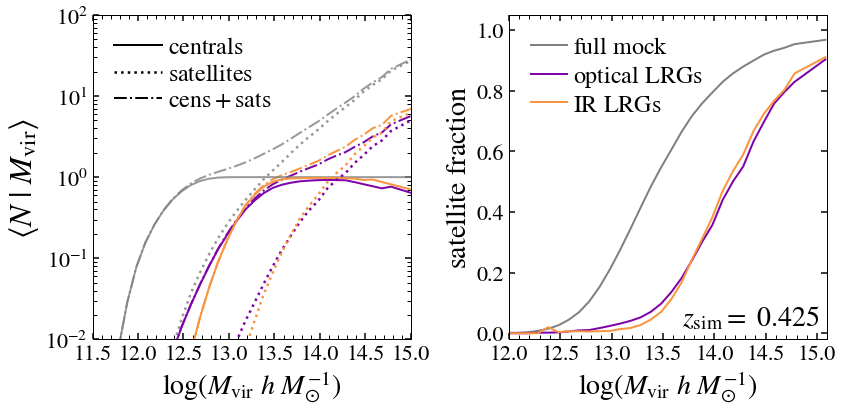

In [7]:
from matplotlib.lines import Line2D

fig, axes = plt.subplots(1, 2, figsize=(12,6)) #, sharex=True)

colors = get_colors(2)
for ax in axes:
    ax.tick_params(axis="both", which="major", labelsize=22)
    ax.set_xlabel(fig_labels["log_mvir"], fontsize=28)

ax = axes[0]
ax.set_xlim(11.5,15.0)
ax.set_xticks(np.arange(11.5,15.1,0.5))
ax.set_ylim(0.01,100)
ax.semilogy()

ax.plot(mvir_mids+np.log10(h), mean_num_gal_per_parent_mvir_bin, color="gray", ls="dashdot", alpha=0.8, lw=2, label=r"${\rm centrals + satellites}$")
ax.plot(mvir_mids+np.log10(h), mean_num_opt_lrg_per_parent_mvir_bin, ls="dashdot", color=colors[0], lw=2, label=r"${\rm optical\ LRGs}$")
ax.plot(mvir_mids+np.log10(h), mean_num_IR_lrg_per_parent_mvir_bin, ls="dashdot", color=colors[1], lw=2, label=r"${\rm IR\ LRGs}$")

ax.plot(mvir_mids+np.log10(h), mean_num_cen_per_parent_mvir_bin, color="gray", lw=2, alpha=0.8)
ax.plot(mvir_mids+np.log10(h), mean_num_cen_opt_lrg_per_parent_mvir_bin, color=colors[0], lw=2, label=r"${\rm optical\ LRGs\ (centrals)}$")
ax.plot(mvir_mids+np.log10(h), mean_num_cen_IR_lrg_per_parent_mvir_bin, color=colors[1], lw=2, label=r"${\rm IR\ LRGs\ (centrals)}$")

ax.plot(mvir_mids+np.log10(h), mean_num_sat_per_parent_mvir_bin, color="gray", ls=":", lw=2.5, alpha=0.8)
ax.plot(mvir_mids+np.log10(h), mean_num_sat_opt_lrg_per_parent_mvir_bin, color=colors[0], ls=":", lw=2.5, label=r"${\rm optical\ LRGs\ (satellites)}$")
ax.plot(mvir_mids+np.log10(h), mean_num_sat_IR_lrg_per_parent_mvir_bin, color=colors[1], ls=":", lw=2.5, label=r"${\rm IR\ LRGs\ (satellites)}$")

legend_elements = [Line2D([0], [0], color="black", lw=2, label=r"${\rm centrals}$"),
                   Line2D([0], [0], color="black", lw=2.5, ls=":", label=r"${\rm satellites}$"),
                   Line2D([0], [0], color="black", lw=2, ls="dashdot", label=r"${\rm cens + sats}$"),]
ax.legend(handles=legend_elements, fontsize=24, labelspacing=0.2, handletextpad=0.25, loc=2)#, frameon=True)

# ax1 = ax.twiny()
# ax1.set_xticks([])
# legend_elements = [Line2D([0], [0], color=colors[0], ls="dashdot", lw=2, label=r"${\rm optical\ LRGs}$"),
#                    Line2D([0], [0], color=colors[1], ls="dashdot", lw=2, label=r"${\rm IR\ LRGs}$"),]
# ax1.legend(handles=legend_elements, fontsize=20, markerfirst=False, labelspacing=0.2, handletextpad=0.5, loc=4)#, frameon=True)

# ax.text(*get_corners(ax, margin=0.05, logy=True)["lower_right"], scatter_label, ha="right", va="bottom", fontsize=20)

ax.set_ylabel(r"$\langle N\ |\ M_{\rm vir}\rangle$", fontsize=32)

ax = axes[1]
ax.set_xlim(12,15.1)
ax.set_xticks(np.arange(12,15.2,0.5))
ax.set_ylim(-0.02,1.05)
ax.set_ylabel(r"${\rm satellite\ fraction}$", fontsize=28)
ax.plot(mvir_mids+np.log10(h), sat_frac_per_parent_mvir_bin, color="gray", lw=2, label=r"${\rm full\ mock}$")
ax.plot(mvir_mids+np.log10(h), sat_frac_opt_lrg_per_parent_mvir_bin, color=colors[0], lw=2, label=r"${\rm optical\ LRGs}$")
ax.plot(mvir_mids+np.log10(h), sat_frac_IR_lrg_per_parent_mvir_bin, color=colors[1], lw=2, label=r"${\rm IR\ LRGs}$")

ax.legend(fontsize=24, labelspacing=0.2, handletextpad=0.25, handlelength=1.5)

ax.text(*get_corners(ax, margin=0.025)["lower_right"], r"$z_{\rm sim}=\ $" + f"${zsim:.3f}\ $", ha="right", va="bottom", fontsize=28)

plt.tight_layout()

figname = f"{BASEDIR}/figures/hod-lrg_{zsnap_tag}_{abs_mag_lim_tag}_{rp_use_tag}.png"
print(figname)

plt.savefig(figname, dpi=200, bbox_inches="tight", pad_inches=0.1)

plt.show()


<a class="anchor" id="hod_fit"></a>
## Fit predicted HOD to Rongpu's DESI-like LRG analytic HOD

[BACK TO TOP](#outline)

$$
\langle N_{\rm cen}|M_{\rm vir}\rangle = \frac{1}{2}\left(1 + {\rm erf}{\left[\frac{\log(M_{\rm vir})-\log(M_{\rm min})}{\sigma_{\log M}} \right]} \right) 
$$

$$
\langle N_{\rm sat}|M_{\rm vir}\rangle = {\left(\frac{M_{\rm vir}-M_0}{M_1} \right)}^{\alpha}
$$

No satellite galaxies in halos with $M_{\rm vir}<M_0$; satellite galaxies can exist in halos with no cenetral galaxy.

In [9]:
from scipy import special as sp

def n_cen_m_vir(log_m_vir, zmin=None, zhou_data=None, log_m_min=None, sigma_log_m=None):
    this_zhou_data = zhou_data[zmin==np.round(zhou_data["zsim"],1)]
    
    names = this_zhou_data.colnames
    data  = np.array(this_zhou_data)[0]

    params = {}
    for i in range(len(names)):
        params[names[i]] = data[i]

    log_m_min   = params[log_m_min]
    sigma_log_m = params[sigma_log_m]
    return 0.5*( 1. + sp.erf( (log_m_vir - log_m_min) / sigma_log_m ) )


def n_sat_m_vir(log_m_vir, zmin=None, zhou_data=None, log_m0=None, log_m1=None, alpha=None):
    this_zhou_data = zhou_data[zmin==np.round(zhou_data["zsim"],1)]

    names = this_zhou_data.colnames
    data  = np.array(this_zhou_data)[0]

    params = {}
    for i in range(len(names)):
        params[names[i]] = data[i]

    m0    = 10**params[log_m0]
    m1    = 10**params[log_m1]
    alpha = params[alpha]
    return ( (10**log_m_vir - m0) / m1 )**alpha


zhou_data = ascii.read("zhou_lrg_hod.csv")
zhou_data.show_in_notebook()

# this_hod_data = Table(np.load(f"{BASEDIR}/data/hod_zsim{str(zsim).replace('.','p')}_{band}.npy"))
                   

idx,pz_bin,zsim,log_Mmin_mean,log_Mmin_med,log_Mmin_6d,sigma_logM_mean,sigma_logM_med,sigma_logM_6d,alpha_mean,alpha_med,alpha_6d,logM0_mean,logM0_med,logM0_6d,logM1_mean,logM1_med,logM1_6d,bias_mean,bias_med,bias_6d,fsat_mean,fsat_med,fsat_6d,chisq_6d,p-val_6d
0,0p41-0p50,0.42531,12.90+0.05−0.05,12.89,12.85,0.17+0.13−0.13,0.16,0.03,1.28+0.09−0.10,1.31,1.29,12.13+0.64−0.71,12.19,12.41,13.99+0.05−0.05,14.0,13.97,1.89+0.03−0.03,1.88,1.89,0.15+0.02−0.02,0.15,0.15,4.57,0.71
1,0p50-0p61,0.52323,12.92+0.03−0.04,12.92,12.89,0.12+0.09−0.09,0.11,0.0,1.11+0.22−0.21,1.14,1.1,12.73+0.40−0.46,12.88,12.92,13.98+0.07−0.07,13.98,13.95,2.04+0.02−0.02,2.04,2.04,0.13+0.01−0.01,0.13,0.13,9.87,0.2
2,0p61-0p72,0.62813,12.86+0.05−0.05,12.85,12.86,0.20+0.13−0.13,0.19,0.28,1.31+0.06−0.06,1.33,1.32,11.94+0.58−0.62,11.97,11.96,13.92+0.04−0.04,13.92,13.91,2.07+0.03−0.03,2.07,2.04,0.16+0.01−0.01,0.16,0.16,6.86,0.44


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in power
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in true_divide
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


/Users/aberti/Desktop/research/desi_lrg_sham/figures/hod-compare_zhou+21_Mz.png


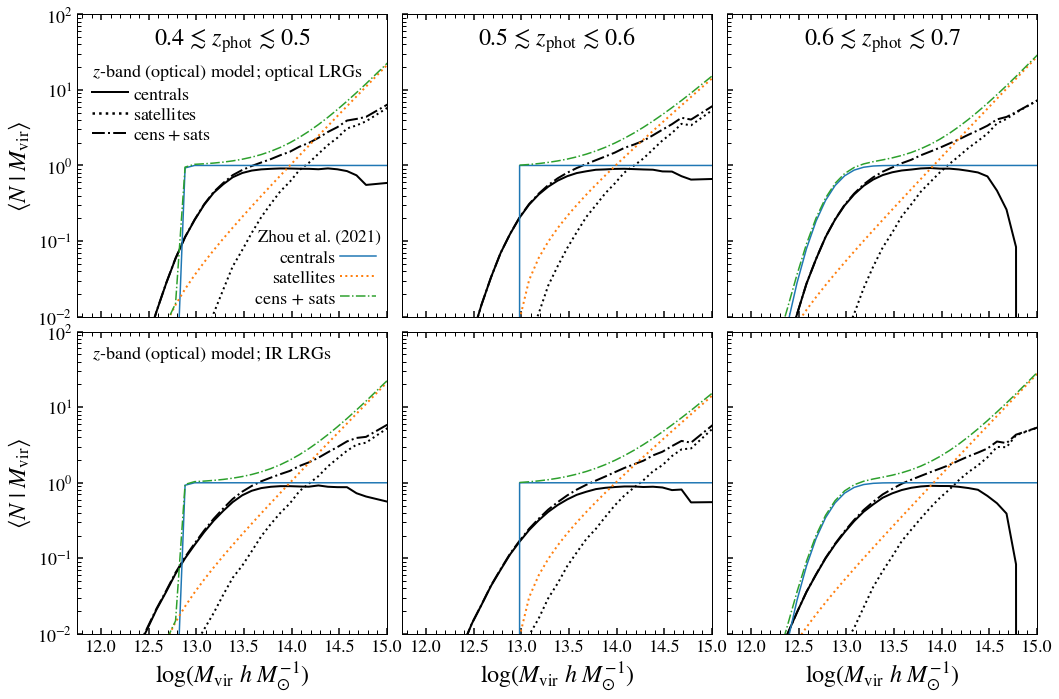

In [175]:
this_band = "Mz"
log_mvir = this_hod_data["mvir_mids"]+np.log10(h)
# log_mvir = np.linspace(np.min(mvir_mids), np.max(mvir_mids), 1000)

model_type = "optical" if this_band=="Mz" else "IR"

fig, axes = plt.subplots(2, 3, figsize=(15,10), sharex=True, sharey=True)

for ax in np.concatenate(axes):
    ax.set_xlim(11.75,15)
    ax.set_ylim(0.01,100)
    ax.semilogy()
    ax.tick_params(axis="both", which="major", labelsize=18)
    
for ax in axes[:,0]:
    ax.set_ylabel(r"$\langle N\ |\ M_{\rm vir}\rangle$", fontsize=24)

for ax in axes[1,:]:
    ax.set_xticks(np.arange(12,15.1,0.5))
    ax.set_xlabel(fig_labels["log_mvir"], fontsize=24)

pct_diff_all = {}
    
for col,this_zmin in enumerate((0.4,0.5,0.6)):
    pct_diff_all[this_zmin] = {}
    #-- Zhou+ 21 DESI-like LRG HOD analytic fits
    for row,ax in enumerate(axes[:,col]):
        ax2 = ax.twinx()
        ax2.set_xlim(axes[0][0].get_xlim())
        ax2.set_ylim(axes[0][0].get_ylim())
        ax2.semilogy()

        kwargs_cen = dict(zhou_data=zhou_data, zmin=this_zmin, log_m_min="log_Mmin_6d", sigma_log_m="sigma_logM_6d")
        kwargs_sat = dict(zhou_data=zhou_data, zmin=this_zmin, log_m0="logM0_6d", log_m1="logM1_6d", alpha="alpha_6d")

        ax2.plot( log_mvir, n_cen_m_vir(log_mvir, **kwargs_cen), lw=1.5, color="C0", label="centrals")
        ax2.plot( log_mvir, n_sat_m_vir(log_mvir, **kwargs_sat), ls=":", lw=2, color="C1", label="satellites")
        ax2.plot( log_mvir, n_cen_m_vir(log_mvir, **kwargs_cen) + n_sat_m_vir(log_mvir, **kwargs_sat), lw=1.5, ls="dashdot", color="C2", label="cens + sats")

        ax2.get_yaxis().set_visible(False)
        if (col==0) & (row==0):
            ax2.text(13.65, 0.1, "Zhou et al. (2021)", fontsize=17)
            ax2.legend(loc=(0.55,0.01), fontsize=18, labelspacing=0.2, handletextpad=0.25, markerfirst=False)
        if row==0:
            title = f"${this_zmin}\ \lesssim\ $" + r"$z_{\rm phot}$" + f"$\ \lesssim\ {this_zmin+0.1}$"
            ax2.text(13.375, 30, title, fontsize=24, ha="center", va="bottom")
    zsims = {"0.4":0.42531, "0.5":0.52323, "0.6":0.62813}
    this_zsim = zsims[str(this_zmin)]
    
    this_hod_data = Table(np.load(f"{BASEDIR}/data/hod_zsim{str(this_zsim).replace('.','p')}_{this_band}.npy"))

    ax_opt = axes[0][col]
    ax_opt.plot( this_hod_data["mvir_mids"]+np.log10(h), this_hod_data["mean_num_cen_opt_lrg_per_parent_mvir_bin"], color="k", lw=2, label="" )
    ax_opt.plot( this_hod_data["mvir_mids"]+np.log10(h), this_hod_data["mean_num_sat_opt_lrg_per_parent_mvir_bin"], color="k", lw=2, ls=":", label="" )
    ax_opt.plot( this_hod_data["mvir_mids"]+np.log10(h), this_hod_data["mean_num_opt_lrg_per_parent_mvir_bin"], color="k", lw=2, ls="dashdot", label="" )

    am_cen = n_cen_m_vir(log_mvir, **kwargs_cen).data
    sm_cen = this_hod_data["mean_num_cen_opt_lrg_per_parent_mvir_bin"].data        
    pd_cen = (am_cen - sm_cen) / am_cen# + sm_cen)
    
    am_sat = n_sat_m_vir(log_mvir, **kwargs_sat).data
    sm_sat = this_hod_data["mean_num_sat_opt_lrg_per_parent_mvir_bin"].data        
    pd_sat = (am_sat - sm_sat) / am_sat# + sm_sat)

    am_all = n_cen_m_vir(log_mvir, **kwargs_cen).data + n_sat_m_vir(log_mvir, **kwargs_sat).data
    sm_all = this_hod_data["mean_num_opt_lrg_per_parent_mvir_bin"].data        
    pd_all = (am_all - sm_all) / am_all# + sm_all)
    
    pct_diff_all[this_zmin]["cen_opt"] = pd_cen
    pct_diff_all[this_zmin]["sat_opt"] = pd_sat
    pct_diff_all[this_zmin]["all_opt"] = pd_all
                              
    ax_IR = axes[1][col]
    ax_IR.plot( this_hod_data["mvir_mids"]+np.log10(h), this_hod_data["mean_num_cen_IR_lrg_per_parent_mvir_bin"], color="k", lw=2, label="" )
    ax_IR.plot( this_hod_data["mvir_mids"]+np.log10(h), this_hod_data["mean_num_sat_IR_lrg_per_parent_mvir_bin"], color="k", lw=2, ls=":", label="" )
    ax_IR.plot( this_hod_data["mvir_mids"]+np.log10(h), this_hod_data["mean_num_IR_lrg_per_parent_mvir_bin"], color="k", lw=2, ls="dashdot", label="" )

    am_cen = n_cen_m_vir(log_mvir, **kwargs_cen).data
    sm_cen = this_hod_data["mean_num_cen_IR_lrg_per_parent_mvir_bin"].data        
    pd_cen = (am_cen - sm_cen) / am_cen# + sm_cen)
    
    am_sat = n_sat_m_vir(log_mvir, **kwargs_sat).data
    sm_sat = this_hod_data["mean_num_sat_IR_lrg_per_parent_mvir_bin"].data        
    pd_sat = (am_sat - sm_sat) / am_sat# + sm_sat)

    am_all = n_cen_m_vir(log_mvir, **kwargs_cen).data + n_sat_m_vir(log_mvir, **kwargs_sat).data
    sm_all = this_hod_data["mean_num_IR_lrg_per_parent_mvir_bin"].data        
    pd_all = (am_all - sm_all) / am_all# + sm_all)
    
    pct_diff_all[this_zmin]["cen_IR"] = pd_cen
    pct_diff_all[this_zmin]["sat_IR"] = pd_sat
    pct_diff_all[this_zmin]["all_IR"] = pd_all

legend_elements = [Line2D([0], [0], color="black", lw=2, label=r"${\rm centrals}$"),
                   Line2D([0], [0], color="black", lw=2.5, ls=":", label=r"${\rm satellites}$"),
                   Line2D([0], [0], color="black", lw=2, ls="dashdot", label=r"${\rm cens + sats}$"),]
axes[0][0].legend(handles=legend_elements, fontsize=18, labelspacing=0.2, handletextpad=0.25, loc=(0.025,0.55))

axes[0][0].text(11.9, 15, f"${this_band[1:]}$-band ({model_type}) model; optical LRGs", fontsize=18)
axes[1][0].text(11.9, 45, f"${this_band[1:]}$-band ({model_type}) model; IR LRGs", fontsize=18)

plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)

figname = f"{BASEDIR}/figures/hod-compare_zhou+21_{this_band}.png"
print(figname)
plt.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=300)

plt.show()


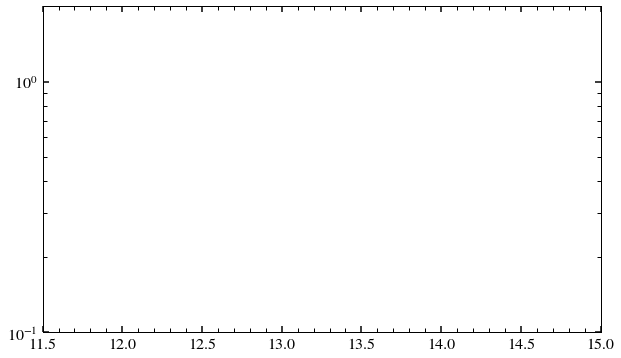

In [167]:
this_data = pct_diff_all[0.6]

fig, ax = plt.subplots(1, 1, figsize=(10,6))

# ax.plot(log_mvir, this_data["cen_opt"])
# ax.plot(log_mvir, this_data["sat_opt"])
# ax.plot(log_mvir, this_data["all_opt"])

# ax.plot(log_mvir, this_data["cen_IR"])
# ax.plot(log_mvir, this_data["sat_IR"])
# ax.plot(log_mvir, this_data["all_IR"])

ax.semilogy()
ax.set_xlim(11.5,15)
ax.set_ylim(0.1,2)

plt.show()


<a class="anchor" id="clust"></a>
# Clustering

<a class="anchor" id="clust_mock_lrg"></a>
### Data versus mock LRGs

[BACK TO TOP](#outline)

In [ ]:
# MW1 0.4 w4
# popt = [0.200, 4.963, -6.58, -39.504]
# MW1 0.5 w4
# popt = [0.116, 3.049, -1.798, 63.452]
# MW1 0.6 w4
# popt = [0.225, 5.709, -3.598, 24.172]

# Mz 0.4 w4
# popt = [0.130, 3.253, 11.648, 372.468]
# Mz 0.5 w4
# popt = [0.001, 0.426, 32.792, 834.502]
# Mz 0.6 _4
# popt = [0.122, 3.133, 15.853, 468.321]

popt = {"MW1":{0.4:[0.200, 4.963, -6.58, -39.504],
               0.5:[0.116, 3.049, -1.798, 63.452],
               0.6:[0.225, 5.709, -3.598, 24.172],
              },
        "Mz": {0.4:[0.130, 3.253, 11.648, 372.468],
               0.5:[0.001, 0.426, 32.792, 834.502],
               0.6:[0.122, 3.133, 15.853, 468.321],
              },
       }

popt_los = popt[band][zmin][2:]

print(popt_los)


In [ ]:
n_iter   = 1
boxsize  = get_boxsize(sim_tag)
nthreads = 2

lrg_mask_opt = cat["LRG_opt"]==True
lrg_mask_IR  = cat["LRG_IR"]==True

def _plot(selection, band=None, zmin=None, N_chisq=1, rp_use_range=None, popt_los=None, save=False):
    colors = get_colors(2)
    #-- "LXL" for IR DESI LRG selection
    if selection=="IR":
        print("IR")
        cross = "LXL"
        lrg_type = ""
        this_lrg_mask = lrg_mask_IR
        color = colors[1]
    #-- "LXLopt" for optical DESI LRG selection
    elif ("opt" in selection) | (selection=="optical"):
        selection = "opt"
        cross = "LXLopt"
        lrg_type = "opt"
        this_lrg_mask = lrg_mask_opt
        color = colors[0]
    else:
        raise Exception()

    fig, ax = plt.subplots(1, 1, figsize=(7,6))

    ax.set_xlim(0.04,40)
    ax.set_ylim(50,250)
    ax.tick_params(axis="both", which="major", labelsize=24)

    #-- data clustering measurements with no absolute magnitude bins contained in v0.2/
    fpath = f"{BASEDIR}/clustering/{zmag_tag}/{abs_mag_lim_tag}/no_abs_mag_bins"
    wp_fname = f"{fpath}/wp/{cat_tag}_{cross}_pimax{int(pimax)}.txt"
    assert(os.path.exists(wp_fname))
    data = ascii.read(wp_fname)
    rp_cen = h*data["rp_cen"]
    wp     = h*data["wp"]
    wp_err = h*np.sqrt(data["wp_err"])

    data_label  = r"${\rm optical\ LRG})$" if lrg_type=="opt" else r"${\rm IR\ LRG})$"
    zphot_label = r"${\rm data}$ "+ f"$({zmin}$" + r"$\ <z_{\rm phot}<\ $" + f"${zmax})$"  #;\ $" + data_label
    ax.errorbar(rp_cen, rp_cen*wp, yerr=rp_cen*wp_err, label=zphot_label, color="black", marker="o", ms=5, ls="", ecolor="black", alpha=0.8)
    # ax.errorbar(rp_cen, wp, yerr=wp_err, label=zphot_label, color="black", marker="o", ms=5, ls="", ecolor="gray", alpha=0.8)

    ax.set_xlabel(fig_labels["rp"], fontsize=28)
    ax.set_ylabel(fig_labels["rpwp"], fontsize=28)

    N_lrg_opt = len(cat[lrg_mask_opt])
    N_lrg_IR  = len(cat[lrg_mask_IR])

    labels = {"opt":r"${\rm mock\ optical\ LRGs}$" + "\n" + f"$(N={N_lrg_opt})$",
              "IR":r"${\rm mock\ IR\ LRGs}$" + "\n" +  f"$(N={N_lrg_IR})$",
             }
    
    #-- compute sigma_los for specified parameterization
    if popt_los is None:
        sigma_los = np.zeros(len(cat))
        zphot_err = False
    else:
        m_los, b_los = popt_los
        sigma_los = m_los*cat[band].data + b_los
        zphot_err = True
    sigma_los[np.where(sigma_los < 0)[0]] = 0
    print(popt_los)

    out = []
    for (u,v,w) in (("x","y","z"),("y","z","x"),("z","x","y")):
        xx = cat[u][this_lrg_mask]
        yy = cat[v][this_lrg_mask]
        zz = cat[w][this_lrg_mask]
        z_scatter = np.array([np.random.normal(zz, sigma_los[this_lrg_mask], len(zz)) for idx in range(n_iter)])
        z_scatter[z_scatter < 0] = np.array(boxsize - np.abs(z_scatter[z_scatter < 0])%boxsize)
        z_scatter[z_scatter > boxsize] = np.array(z_scatter[z_scatter > boxsize]%boxsize)

        out.append([wp_corrfunc(boxsize, pimax, nthreads, bin_file_comoving, xx, yy, z_s, output_rpavg=False)["wp"] for z_s in z_scatter])

    out = np.concatenate(out).T

    wp_mean = np.mean(out, axis=1)
    std     = np.std(out, axis=1)

    model = Table([rp_mids,wp_mean,std], names=("rp_cen","wp","wp_err"))

    wp_mod     = h*model["wp"]
    wp_mod_err = h*model["wp_err"]

    ax.plot(rp_cen, rp_cen*wp_mod, color=color, label=labels[selection], lw=2)
    #ax.plot(rp_cen, wp_mod, color=color, label=labels[selection], lw=2)

    # ax.legend(markerfirst=False, numpoints=2, fontsize=20, loc=1, handletextpad=0.2)
    ax.legend(numpoints=2, handlelength=2, fontsize=24, loc=(0.01,0.625), handletextpad=0.2)
    ax.semilogx()
    # ax.loglog()

    label = r"$z_{\rm sim}=\ $" + f"${zsim:.3f}$"# + "\n"
    if zphot_err==True:
        figname = f"{BASEDIR}/figures/wp_model-vs-data/rpmin0p1Mpch_brightest-mag-bin-rp1Mpch/{band}/{cat_tag[:-6]}/wp_{cat_tag[:-6]}_{abs_mag_lim_tag}_LRG{lrg_type}_data-vs-mock.png"
    else:
        figname = f"{BASEDIR}/figures/wp_model-vs-data/rpmin0p1Mpch_brightest-mag-bin-rp1Mpch/{band}/{cat_tag[:-6]}/wp_{cat_tag[:-6]}_{abs_mag_lim_tag}_{rp_use_tag}_LRG{lrg_type}_data-vs-mock_no-photoz-err.png"
    ax.text(*get_corners(ax, logx=True, margin=0.025)["lower_left"], label, fontsize=28, va="bottom", ha="left")

    rp_use_min, rp_use_max = rp_use_range
    if rp_use_min != None:
        ax.fill_between((ax.get_xlim()[0],rp_use_min), ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)
    if rp_use_max != None:
        ax.fill_between((rp_use_max,ax.get_xlim()[-1]), ax.get_ylim()[1]*np.ones(2), color="gray", alpha=0.1)
    plt.tight_layout()
    
    if save:
        print(f"Saving {figname}...")
        plt.savefig(figname, dpi=200, bbox_inches="tight", pad_inches=0.1)
    plt.show()
    


In [ ]:
%%time

#-- default LOS scatter implementation for this band and zmin
# kwargs = dict(band=band, zmin=zmin, rp_use_range=(0.1,None), save=True)

#-- altermative implementations
kwargs = dict(band=band, zmin=zmin, rp_use_range=(0.1,None), popt_los=popt_los, save=True)

selection = "opt"
_plot(selection, **kwargs)

selection = "IR"
_plot(selection, **kwargs)


<a class="anchor" id="not_lrg"></a>

# What's the deal with those central galaxies in massive halos that aren't LRGs?

[BACK TO TOP](#outline)

In [ ]:
parent_mvir_14p5 = log_parent_mvir > 14.5

not_lrg_opt = cat[~lrg_mask_opt & cenmask & parent_mvir_14p5]
not_lrg_IR  = cat[~lrg_mask_IR & cenmask & parent_mvir_14p5]


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))

try:
    colors
except:
    colors = get_colors(2)

ax.scatter(not_lrg_IR[band], not_lrg_IR[f"r-{band[1:]}"], s=100, marker="+", color=colors[1], label=r"${\rm IR\ selection}$ " + f"$(N={len(not_lrg_IR)})$")
ax.scatter(not_lrg_opt[band], not_lrg_opt[f"r-{band[1:]}"], s=25, alpha=0.4, color=colors[0], label=r"${\rm optical\ selection}$ " + f"$(N={len(not_lrg_opt)})$")

ax.tick_params(axis="both", which="major", labelsize=20, direction="in")

ax.legend(handletextpad=0.1, borderpad=0.25, labelspacing=0.25, fontsize=18, frameon=True, loc=3)

mag_label = r"${\rm model}\ M_{\rm z}$" if (band=="Mz") else r"$M_{\rm W1}$"
ax.set_xlabel(mag_label, fontsize=20)
if band=="Mz":
    ax.set_xlim(-20.5,-25.5)
    ax.set_ylim(0.25,3)
elif band=="MW1":
    ax.set_xlim(-22.5,-26.2)
    ax.set_ylim(2.25,5.75)
ax.set_ylabel(r"${\rm model}\ $" + f"$(r-{band[1:]})$", fontsize=20)

ax.text(*get_corners(ax)["upper_left"], r"$z_{\rm sim}=\ $" + f"${zsim:.3f}$", fontsize=20, ha="left", va="top")
plt.tight_layout()

figname = f"{BASEDIR}/figures/notLRG-outliers_{zsnap_tag}_{abs_mag_lim_tag}_{rp_use_tag}.png"
print(figname)
# plt.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=200)

plt.show()


In [ ]:
data_table = Table(np.load(f"{BASEDIR}/mags_z0p40-0p70.npy"))
# print(data_table.colnames)

g, r, z, W1 = data_table["g"], data_table["r"], data_table["z"], data_table["W1"]
Mg, Mr, Mz, MW1 = data_table["Mg"], data_table["Mr"], data_table["Mz"], data_table["MW1"]
zfiber, pz = data_table["zfiber"], data_table["pz"]

lrg_opt = data_table["LRG_opt"]==True
lrg_IR  = data_table["LRG_IR"]==True

lrg_opt_mask = lrg_opt # & (Mz < -23.8)
lrg_IR_mask  = lrg_IR # & (Mz < -23.8)

not_lrg_opt_mask = ~lrg_opt & (Mz < -23.8)
not_lrg_IR_mask  = ~lrg_IR & (Mz < -23.8)


In [ ]:
selection = "optical"

kwargs = dict(s=3, alpha=0.8, cmap="plasma")
DS     = 2

bg_kwargs = dict(s=3, alpha=0.05, color="gray")
bg_DS     = 10

line_kwargs = dict(lw=3, color="k")

if selection=="IR":
    mask    = not_lrg_IR_mask
    bg_mask = lrg_IR_mask
    title   = r"${\rm IR\ Selection\ (gray=LRG;\ color}={\rm bright}\ (M_z < -23.8)\ {\rm but\ NOT\ LRG)}$"
else:
    selection = "optical"
    mask    = not_lrg_opt_mask
    bg_mask = lrg_opt_mask
    title   = r"${\rm Optical\ Selection\ (gray=LRG;\ color}={\rm bright}\ (M_z < -23.8)\ {\rm but\ NOT\ LRG)}$"

def lrg_contour(ax, x, y, bg_mask=bg_mask, bg_DS=bg_DS, leg=False):
    H, X, Y = np.histogram2d( x[bg_mask][::bg_DS], y[bg_mask][::bg_DS], bins=(80,80), range=(ax.get_xlim(),ax.get_ylim()) )
    XX = 0.5*(X[:-1]+X[1:])
    YY = 0.5*(Y[:-1]+Y[1:])
    levels = np.logspace(1,np.log10(1.5*np.max(H)),5)
    ax.contourf(XX, YY, H.T, colors="gray", alpha=0.3, levels=levels)
    ax.contour(XX, YY, H.T, colors="black", linewidths=1, levels=levels)
    

fig, axes = plt.subplots(2, 2, figsize=(10,10))

ax = axes[0][0]
ax.set_xlim(0.2, 2.8)
ax.set_ylim(-1, 3)
ax.set_xlabel("$r-z$")
ax.set_ylabel("$z-W1$")
ax.set_xticks(np.arange(0.5,3.0,0.5))
ax.set_title("Stellar rejection cut", fontsize=18)

x, y = r-z, z-W1
lrg_contour(ax, x, y)
# ax.scatter(x[bg_mask][::bg_DS], y[bg_mask][::bg_DS], **bg_kwargs)
ax.scatter(x[mask][::DS], y[mask][::DS], c=pz[mask][::DS], **kwargs)
# stellar rejection cut
# z - W1 > 0.8*(r - z) - 0.6
xx = np.linspace(*ax.get_xlim())
yy = 0.8*xx - 0.6
ax.plot(xx, yy, **line_kwargs)

xt = 0.3
ax.text(xt, 2.8, "Gray contours: optical LRG targets", ha="left", va="top", fontsize=16)
ax.text(xt, 2.45, "Color points: bright $(M_z < -23.8)$", ha="left", va="top", fontsize=16)
ax.text(xt, 2.2, " red-sequence but $not$ LRG target", ha="left", va="top", fontsize=16)


ax = axes[0][1]
ax.set_xlim(-0.1, 4.5)
ax.set_ylim(0, 2.7)
ax.set_xlabel("$r-W1$")
ax.set_ylabel("$g-r$")
ax.set_xticks(np.arange(0,5,1))
ax.set_title("Faint or blue galaxy cut", fontsize=18)

x, y = r-W1, g-r
lrg_contour(ax, x, y)    
# ax.scatter(x[bg_mask][::bg_DS], y[bg_mask][: :bg_DS], **bg_kwargs)
ax.scatter(x[mask][::DS], y[mask][::DS], c=pz[mask][::DS], **kwargs)
# eliminate low-redshift or bluer objects
# ( (g - W1 > 2.6) AND (g - r > 1.4) ) OR (r - W1 > 1.8)
g_r  = np.linspace(*ax.get_ylim(), 100)
r_W1 = np.linspace(*ax.get_xlim(), 100)
line_mask = ( (g_r < 2.6 - r_W1) & (g_r < 1.4) ) | (r_W1 < 1.8)
ax.plot( r_W1[ r_W1 <= 1.2 ], (-r_W1 + 2.6)[ r_W1 <= 1.2 ], **line_kwargs )
ax.plot( r_W1[ (r_W1 >= 1.2) & (r_W1 <= 1.8) ], 1.4*np.ones(len(r_W1))[ (r_W1 >= 1.2) & (r_W1 <= 1.8) ], **line_kwargs )
ax.plot( 1.8*np.ones(len(g_r))[ g_r <= 1.4 ], g_r[ g_r <= 1.4 ], **line_kwargs )


ax = axes[1][0]
ax.set_xlim(16.5, 21.6)
ax.set_ylim(0.25, 2.75)
ax.set_xlabel("$z$")
ax.set_ylabel("$r-z$")
ax.set_xticks(np.arange(17,22,1))
ax.text(*get_corners(ax, margin=0.04)["lower_right"], "Color-dependent\nmagnitude cut\n(brightest galaxies)", ha="right", va="bottom", fontsize=18)

x, y = z, r-z
lrg_contour(ax, x, y)    
# ax.scatter(x[bg_mask][::bg_DS], y[bg_mask][::bg_DS], **bg_kwargs)
cbar = ax.scatter(x[mask][::DS], y[mask][::DS], c=pz[mask][::DS], **kwargs)
# color-dependent magnitude limit selects only most luminous objects at given redshift
# ( r - z > 0.45*(z - 16.83) ) AND (r - z > 0.19*(z - 13.80) )
# r - z > 0.7
xx = np.linspace(*ax.get_xlim(), 100)
m1, m2, m3 = (xx <= 17.48), ((xx >= 17.48) & (xx <= 19.04)), (xx >= 19.04)
ax.plot(xx[m1], 0.7*np.ones(len(xx))[m1], **line_kwargs)
ax.plot(xx[m2], 0.19*(xx - 13.80)[m2], **line_kwargs)
ax.plot(xx[m3], 0.45*(xx - 16.83)[m3], **line_kwargs)


ax = axes[1][1]
ax.set_xlim(17, 21.7)
ax.set_ylim(18, 23)
ax.set_xlabel("$z$")
ax.set_ylabel(r"$z_{\rm fiber}$")
ax.set_xticks(np.arange(17,22,1))
ax.text(*get_corners(ax, margin=0.04)["lower_right"], r"DESI fiber mag. cut" + "\n(secure spec. redshifts)", ha="right", va="bottom", fontsize=18)

x, y = z, zfiber
lrg_contour(ax, x, y, leg=True)
# ax.scatter(x[bg_mask][::bg_DS], y[bg_mask][::bg_DS], **bg_kwargs)
ax.scatter(x[mask][::DS], y[mask][::DS], c=pz[mask][::DS], **kwargs)
# ensure targets yield secure spec-z measurements
# zfiber < 21.5
ax.plot(ax.get_xlim(), 21.5*np.ones(2), **line_kwargs)

# ax = axes[1][0]
# ax.set_xlim(16.2, 20.5)
# ax.set_ylim(0.3, 5)
# ax.set_xlabel("$W1$")
# ax.set_ylabel("$r-W1$")
# ax.set_xticks(np.arange(17,21,1))

# x, y = W1, r-W1
# ax.scatter(x[bg_mask][::bg_DS], y[bg_mask][::bg_DS], **bg_kwargs)
# ax.scatter(x[mask][::DS], y[mask][::DS], c=pz[mask][::DS], **kwargs)

# ax = axes[1][2]
# ax.set_xlim(-20.5,-25.5)
# ax.set_ylim(0, 2.7)
# ax.set_xlabel("$M_z$")
# ax.set_ylabel("$r-z$")
# ax.set_xticks(np.arange(-25,-20,1))

# x, y = Mz, r-z
# ax.scatter(x[bg_mask][::bg_DS], y[bg_mask][::bg_DS], **bg_kwargs)
# ax.scatter(x[mask][::DS], y[mask][::DS], c=pz[mask][::DS], **kwargs)


#cax = plt.axes([0.9125,0.125,0.015,0.755])
cax = plt.axes([0.9125,0.125,0.020,0.755])
fig.colorbar(cbar, cax=cax).set_ticks(np.arange(0.4,0.71,0.05))
cax.tick_params(axis="both", which="both", labelsize=20)
cax.set_ylabel(r"$z_{\rm phot}$", fontsize=30)
#cax.yaxis.label.set_size(32)

for ax in np.concatenate(axes):
    ax.tick_params(axis="both", which="both", labelsize=20)
    ax.xaxis.label.set_size(24)
    ax.yaxis.label.set_size(24)
    
plt.subplots_adjust(hspace=0.2, wspace=0.25)

figname = f"{BASEDIR}/figures/notLRG-outliers_{selection}.png"
print(figname)
plt.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=300)

plt.show()


<a class="anchor" id="clust_data_only"></a>
### DR9 correlation functions (data only)

In [ ]:
# fig, axes = plt.subplots(2, 3, figsize=(16,12), sharex=True, sharey=True)

# abs_mag_lim_tag = "no_abs_mag_cut"
# abs_mag_bin_tag = "no_abs_mag_bins"

# zrange_list = [(round(zz,1),round(zz+0.1,1)) for zz in np.arange(0.3,0.9,0.1)]

# labels = {"LXL" :r"LRG $\times$ LRG",
#           "LXnL":r"LRG $\times$ not-LRG",
#           "GXG" :r"gal $\times$ gal",}

# for ax,zrange in zip(np.concatenate(axes)[:len(zrange_list)], zrange_list):
#     zmin, zmax = zrange[0], zrange[1]
#     ztag = "{:.2f}-{:.2f}".format(zmin, zmax)
#     ztag = ztag.replace(".","p")

#     for cross in ("LXL","LXnL","GXG"):
#         fname = f"{BASEDIR}/clustering/{zmag_tag}/{abs_mag_lim_tag}/{abs_mag_bin_tag}/wp/z{ztag}_{d}_{cross}_pimax{pimax}.txt"
#         if os.path.exists(fname):

#             data = ascii.read(fname)
#             data.rename_column("rp_cen","rp")
#             rp_cen = h*data["rp"]
#             mask   = (rp_cen > 0.1) & (rp_cen < 50)
#             wp     = h*data["wp"]
#             wp_err = h*np.sqrt(data["wp_err"])
#             ax.plot(rp_cen, rp_cen*wp, ls=":", alpha=0.5, label="", color="gray")
#             ax.errorbar(rp_cen[mask], (rp_cen*wp)[mask], yerr=wp_err[mask], lw=2, ls="", marker="o", ms=4, label=labels[cross])

#     ax.set_xlim(0.1,20)
#     ax.set_ylim(15,150) if d=="north" else ax.set_ylim(15,175)
#     xmin, xmax = ax.get_xlim()
#     ymin, ymax = ax.get_ylim()
#     xt = 10**(np.log10(xmin)+0.5*(np.log10(xmax)-np.log10(xmin)))
#     yt = ymax-0.1*(ymax-ymin)
#     ax.text(xt, yt, f"${zmin}\ $"+r"$<z_{\rm phot}<$"+f"$\ {zmax}$", fontsize=20, ha="center")
#     del zmin, zmax

# for ax in axes[:,0]: ax.set_ylabel(fig_labels["rpwp"], fontsize=20)
# for ax in axes[-1,:]: ax.set_xlabel(fig_labels["rp"], fontsize=20)
# ax.semilogx()
# yticks = np.arange(25,151,25) if d=="north" else np.arange(25,176,25)
# ax.set_yticks(yticks)
# axes[0,0].legend(loc=(0.025,0.275), fontsize=16, labelspacing=0.4, handletextpad=0.8, numpoints=2)
# #axes[-1,-1].axis("off")

# plt.subplots_adjust(hspace=0.02, wspace=0.02)
# #plt.savefig(f"{BASEDIR}/figures/wp_{d}_{zmag_tag}.png", bbox_inches="tight", pad_inches=0.1)

# plt.show()


<a class="anchor" id="mag_fig"></a>
# K-corrected magnitude vs photo-$z$ figure

[BACK TO TOP](#outline)


In [ ]:
# t = Table(np.load(f"{BASEDIR}/mags_z0p40-0p70.npy"))


In [ ]:
# DS = 100
# zz = (0.4,0.5,0.6,0.7)
# fig, axes = plt.subplots(2, 1, figsize=(8,8), sharex=True)

# kwargs = dict(s=2, color="gray", alpha=0.02)
# line_kwargs = dict(color="orangered", lw=2)

# nbin = 3
# zp = t["pz"]

# ylims = ((-20.8,-23.0), (-21.4,-24.5))

# for idx,ax,b,dmag,ylim in zip(range(3),axes,("Mz","MW1"),(0.25,0.3),ylims):
#     mags = t[b]
#     ax.set_xlim(0.395,0.705)
#     ax.set_ylim(ylim)
#     ax.tick_params(axis="both", which="major", labelsize=20)
#     ax.hexbin(zp[::DS], mags[::DS], cmap="gray_r", gridsize=(500,500), bins="log")#, **kwargs)
    
#     hlines = [[(i,i+0.1), get_abs_mag_lim(i,b)*np.ones(2)] for i in zz[:-1]]
#     vlines = [[i*np.ones(2), (get_abs_mag_lim(np.round(i-0.1,1),b),ax.get_ylim()[1])] for i in zz]
#     ax.plot(vlines[0][0], vlines[1][1], **line_kwargs)
#     for j in vlines[1:]:
#         ax.plot(*j, **line_kwargs)
#     for h in hlines:
#         for k in range(nbin+1):
#             ax.plot(h[0],h[1]-dmag*k, **line_kwargs)
        
# axes[0].set_yticks(np.arange(-21.0,-23.1,-0.5))
# axes[0].set_ylabel(r"${\rm K}$-${\rm corrected}\ M_{\rm z}$", fontsize=22)
# axes[1].set_yticks(np.arange(-21.5,-24.6,-0.5))
# axes[1].set_ylabel(r"${\rm K}$-${\rm corrected}\ M_{\rm W1}$", fontsize=22)
# axes[1].set_xlabel(r"$z_{\rm phot}$", fontsize=24)

# for ax in axes:
#     ymin, ymax = ax.get_ylim()
#     yt = ymax - 0.02*(ymax-ymin)
#     ax.scatter(zz, yt*np.ones(len(zz)), marker="^", color="orangered", s=80)

# plt.tight_layout()
# plt.subplots_adjust(hspace=0.05)

# figname = f"{BASEDIR}/figures/abs_mag_bins_vs_zphot_z0p4-0p7.png"
# fig.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=200)

# plt.show()


In [ ]:
# fig, axes = plt.subplots(1,2, figsize=(12,4), sharex=True, sharey=True)

# DS = 100

# zfiber_mask = t["zfiber"] > 21
# ax = axes[0]
# ax.scatter(t["pz"][zfiber_mask][::DS],t["z"][zfiber_mask][::DS], s=5, alpha=0.2)
# ax.set_ylim(22,16)

# ax = axes[1]
# ax.scatter(t["pz"][zfiber_mask][::DS],t["W1"][zfiber_mask][::DS], s=5, alpha=0.2)

# plt.tight_layout()

# plt.show()


In [ ]:
# %%time

# # from matplotlib.backends.backend_pdf import PdfPages

# DS  = 10
# dzp = 0.01
# G, R, Z, W, zphot = t["Mg"], t["Mr"], t["Mz"], t["MW1"], t["zphot"]

# for minzp in np.arange(0.4,0.7,dzp):
#     minzp = np.round(minzp,2)
#     maxzp = minzp + dzp
    
#     this_fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

#     zphot_mask = (zphot > minzp) & (zphot < maxzp)

#     ax = axes[0][0]
#     xmin, xmax = -19.5, -25.5
#     ymin, ymax = -1, 5.5
#     ax.set_xlim(xmax, xmin)
#     ax.set_ylim(ymin, ymax)

#     x, y = Z[zphot_mask], (R-Z)[zphot_mask]

#     x0, y0 = np.mean(ax.get_xlim()), np.mean(ax.get_ylim())
#     xs, ys = np.abs(xmax-xmin), np.abs(ymax-ymin)
#     cmask  = (x < xmin) & (x > xmax) & (y > ymin) & (y < ymax)
#     colors = (((x[cmask]-x0)/xs)**2 + ((y[cmask]-y0)/ys)**2)**0.25

#     kwargs = dict(s=10, c=colors[::DS], cmap="gnuplot2", alpha=0.2)

#     ax.scatter(x[cmask][::DS], y[cmask][::DS], **kwargs)
#     ax.set_facecolor("black")
#     ax.set_xlabel("$Z$")
#     ax.set_ylabel("$R-Z$")
#     ax.text(*get_corners(ax)["lower_left"], f"${minzp:.2f} <\ $zphot$\ < {maxzp:.2f}$", ha="left", va="bottom", color="white", fontsize=20)

#     ax = axes[0][1]
#     x, y = W[zphot_mask], (R-W)[zphot_mask]
#     ax.scatter(x[cmask][::DS], y[cmask][::DS], **kwargs)
#     ax.set_facecolor("black")
#     ax.set_xlabel("$W$")
#     ax.set_ylabel("$R-W$")

#     ax = axes[1][0]
#     x, y = R[zphot_mask], (G-R)[zphot_mask]
#     ax.scatter(x[cmask][::DS], y[cmask][::DS], **kwargs)
#     ax.set_facecolor("black")
#     ax.set_xlabel("$R$")
#     ax.set_ylabel("$G-R$")

#     ax = axes[1][1]
#     x, y = W[zphot_mask], (Z-W)[zphot_mask]
#     ax.scatter(x[cmask][::DS], y[cmask][::DS], **kwargs)
#     ax.set_facecolor("black")
#     ax.set_xlabel("$W$")
#     ax.set_ylabel("$Z-W$")

#     plt.tight_layout()

#     zphot_tag = f"z{minzp:.2f}-{maxzp:.2f}"
#     zphot_tag = zphot_tag.replace('.',"p")

#     figname = f"{BASEDIR}/figures/cmd_smear/{zphot_tag}.png"
#     print(figname)
#     this_fig.savefig(figname, bbox_inches="tight", pad_inches=0.1, dpi=100)

# # plt.show()

# # fname = f"{BASEDIR}/figures/cmd_smear.pdf"
# # print("Writing...")
# # with PdfPages(fname) as pdf:
# #     for f in figs:
# #         pdf.savefig(f)

